In [1]:
%matplotlib inline
%load_ext line_profiler

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.integrate
import scipy.stats
import uncertainties.unumpy as unp
from uncertainties import ufloat, correlated_values_norm, correlated_values, covariance_matrix, correlation_matrix
from copy import copy
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from iminuit import Minuit
import statsmodels.stats.correlation_tools
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import os

In [3]:
from effort2.rates.BtoV import BtoV
from effort2.formfactors.BGL import BToDStarBGL
from effort2.formfactors.CLN import BToDStarCLN

In [4]:
result_dir = "results"

In [5]:
tauBzero = 1.520e-12 * 1. / 6.582119e-16 / 1e-9
tauBplus = 1.638e-12 * 1. / 6.582119e-16 / 1e-9

In [6]:
# Florian
Vcb = 41.6558e-3
eta_ew = 1.0066
a = np.array([3.79139e-04, 2.69537e-02])  / Vcb / eta_ew
b = np.array([5.49846e-04, -2.04028e-03]) / Vcb / eta_ew
c = np.array([-4.32818e-04, 5.35029e-03]) / Vcb / eta_ew

test = np.array([
    *a,
    0,
    *b,
    0,
    *c,
    0,
    Vcb
])

In [7]:
# https://arxiv.org/pdf/1403.0635.pdf
#hA1(1) = 0.906(4)(12)
hA1_2014 = ufloat(0.906 , (0.004**2 + 0.012**2)**0.5)

In [8]:
import gvar
lattice = gvar.gload("lattice_data/SynthData.PyDat")
for x in lattice:
    print(f"{x} = {ufloat(gvar.mean(lattice[x]), gvar.sdev(lattice[x]))}")

g(1.03) = 0.372+/-0.014
g(1.10) = 0.331+/-0.013
g(1.17) = 0.291+/-0.017
f(1.03) = 5.80+/-0.11
f(1.10) = 5.52+/-0.11
f(1.17) = 5.27+/-0.16
F1(1.03) = 18.8+/-0.4
F1(1.10) = 17.7+/-0.4
F1(1.17) = 16.6+/-0.7
F2(1.03) = 2.19+/-0.07
F2(1.10) = 1.92+/-0.06
F2(1.17) = 1.71+/-0.09
hA1(1.00) = 0.909+/-0.017
hA1(1.03) = 0.877+/-0.016
hA1(1.10) = 0.807+/-0.016
hA1(1.17) = 0.745+/-0.023
hA2(1.00) = -0.62+/-0.08
hA2(1.03) = -0.59+/-0.08
hA2(1.10) = -0.49+/-0.08
hA2(1.17) = -0.39+/-0.10
hA3(1.00) = 1.26+/-0.08
hA3(1.03) = 1.21+/-0.08
hA3(1.10) = 1.10+/-0.07
hA3(1.17) = 0.99+/-0.09
hV(1.00) = 1.27+/-0.05
hV(1.03) = 1.21+/-0.04
hV(1.10) = 1.08+/-0.04
hV(1.17) = 0.95+/-0.05


In [9]:
import gvar
lattice2 = gvar.gload("lattice_data/FitResults.PyDat")
for x in lattice2:
    print(f"{x} = {ufloat(gvar.mean(lattice2[x]), gvar.sdev(lattice2[x]))}")
    
lattice_coefficients = [
    lattice2["LQCD_a0"],
    lattice2["LQCD_a1"],
    lattice2["LQCD_a2"],
    lattice2["LQCD_b0"],
    lattice2["LQCD_b1"],
    lattice2["LQCD_b2"],
    lattice2["LQCD_c1"],
    lattice2["LQCD_c2"],
]

lattice_coefficients = correlated_values(
    gvar.mean(lattice_coefficients),
    gvar.evalcov(lattice_coefficients)
)

LQCD_a0 = 0.0330+/-0.0012
LQCD_a1 = -0.16+/-0.05
LQCD_a2 = -0.1+/-1.0
LQCD_b0 = 0.01229+/-0.00023
LQCD_b1 = -0.003+/-0.012
LQCD_b2 = 0.1+/-0.5
LQCD_c1 = -0.0058+/-0.0025
LQCD_c2 = -0.01+/-0.09
LQCD_d0 = 0.0509+/-0.0015
LQCD_d1 = -0.33+/-0.07
LQCD_d2 = -0.0+/-1.0
LQCD_RDst = 0.265+/-0.013
LQCDEXP_a0 = 0.0320+/-0.0010
LQCDEXP_a1 = -0.148+/-0.031
LQCDEXP_a2 = -0.60+/-0.22
LQCDEXP_b0 = 0.01246+/-0.00022
LQCDEXP_b1 = 0.004+/-0.005
LQCDEXP_b2 = 0.02+/-0.12
LQCDEXP_c1 = 0.0001+/-0.0009
LQCDEXP_c2 = 0.08+/-0.04
LQCDEXP_c3 = -1.1+/-0.6
LQCDEXP_d0 = 0.0526+/-0.0014
LQCDEXP_d1 = -0.19+/-0.04
LQCDEXP_d2 = -0.0+/-0.9
LQCDEXP_eVcb = 0.00149+/-0.00006
LQCDEXP_RDst = 0.2483+/-0.0013


In [10]:
hA1 = ufloat(lattice["hA1(1.00)"].mean, lattice["hA1(1.00)"].sdev)

hA1_all = [lattice["hA1(1.03)"], lattice["hA1(1.10)"], lattice["hA1(1.17)"]]
hA1_all = correlated_values(
    gvar.mean(hA1_all),
    gvar.evalcov(hA1_all)
)

In [11]:
def make_plot_pretty(ax, bin_edges_all):
    
    tmp = {}
    for voi in fit_vois:
        tmp[voi] = np.array([(lower, upper) for lower, upper in zip(bin_edges_all[voi], bin_edges_all[voi][1:])])
    tmp = np.array([b for voi in fit_vois for b in tmp[voi]])
    
    # We want to show all ticks...
    ax.set_xticks(np.arange(len(tmp)))
    # ... and label them with the respective list entries
    ax.set_xticklabels([f"[{lower:.2f}, {upper:.2f}]" for lower, upper in tmp], rotation=90, fontsize=6)
    ax.xaxis.set_minor_locator(MultipleLocator(1))

    ax.set_xlim(-0.5, 39.5)

    ax.axvline(9.5, color="black")
    ax.axvline(19.5, color="black")
    ax.axvline(29.5, color="black")

    ax.text(0.00+0.12, 1.02, r"$w$", fontsize=10, transform=ax.transAxes)
    ax.text(0.25+0.08, 1.02, r"$\cos \theta_\ell$", fontsize=10, transform=ax.transAxes)
    ax.text(0.50+0.08, 1.02, r"$\cos \theta_V$", fontsize=10, transform=ax.transAxes)
    ax.text(0.75+0.12, 1.02, r"$\chi$", fontsize=10, transform=ax.transAxes)
    
    ax.legend(frameon=False, fontsize="x-small", ncol=1, loc='upper left')
    return ax

markers = {
    15: "v",
    16: "s",
    # (15, 16): "o",
    17: "o",
    18: "X",
    # (17, 18): "o"
    
}

bin_edges_wReco = np.array([*np.linspace(1.0, 1.45, num=10), 1.54]) 
bin_edges_costhetalReco = np.array([*np.linspace(-1, 1, num=11)])
bin_edges_costhetavReco = np.array([*np.linspace(-1, 1, num=11)])
bin_edges_chi_primeReco = np.array([*np.linspace(0, 2*np.pi, num=11)])  # Can be purged soon?
bin_edges_chi_Reco = np.array([*np.linspace(0, 2*np.pi, num=11)])

bin_edges_all = { 
    "wReco": bin_edges_wReco,
    "costhetalReco": bin_edges_costhetalReco,
    "costhetavReco": bin_edges_costhetavReco,
    "chi_primeReco": bin_edges_chi_primeReco,
    "chi_Reco": bin_edges_chi_Reco,
}

fit_vois = ["wReco", "costhetalReco", "costhetavReco", "chi_Reco"]

# Fitting

In [12]:
m_Bzero = 5.27963  # http://pdg.lbl.gov/2018/listings/rpp2018-list-B-zero.pdf
m_Bplus = 5.27932  # http://pdg.lbl.gov/2018/listings/rpp2018-list-B-plus-minus.pdf
# m_Dzero = 1.86483  # http://pdg.lbl.gov/2018/listings/rpp2018-list-D-zero.pdf
# m_Dplus = 1.86965  # http://pdg.lbl.gov/2018/listings/rpp2018-list-D-plus-minus.pdf
m_Dstarzero = 2.00685  # http://pdg.lbl.gov/2018/listings/rpp2018-list-D-star-2007-zero.pdf
m_Dstarplus = 2.01026  # http://pdg.lbl.gov/2018/listings/rpp2018-list-D-star-2010-plus-minus.pdf



BzeroToDStarBGL = BToDStarBGL(
    m_B=m_Bzero,
    m_V=m_Dstarplus,
    exp_coeff_a = a[0:1],
    exp_coeff_b = b[0:1],
    exp_coeff_c = c[0:1],
    chiT_plus33 = 5.131e-4,
    chiT_minus33 = 3.894e-4,
    axialvector_poles = [6.739, 6.750, 7.145, 7.150],
    vector_poles = [6.329, 6.920, 7.020],     
)

BplusToDStarBGL = BToDStarBGL(
    m_B=m_Bplus,
    m_V=m_Dstarzero,
    exp_coeff_a = a[0:1],
    exp_coeff_b = b[0:1],
    exp_coeff_c = c[0:1],
    chiT_plus33 = 5.131e-4,
    chiT_minus33 = 3.894e-4,
    axialvector_poles = [6.739, 6.750, 7.145, 7.150],
    vector_poles = [6.329, 6.920, 7.020], 
)

rate_B0 = BtoV(BzeroToDStarBGL, Vcb=Vcb, eta_EW=eta_ew)
rate_Bp = BtoV(BplusToDStarBGL, Vcb=Vcb, eta_EW=eta_ew)

rate = {
    15: rate_B0,
    16: rate_B0,
    17: rate_Bp,
    18: rate_Bp,
    "B0": rate_B0,
    "B+": rate_Bp
} 

# "B0": r"$B^0 \to D^{*+} \ell \nu_\ell$",
# "B+": r"$B^+ \to D^{*0} \ell \nu_\ell$",
# "e" : r"$B^{(0,+)} \to D^{*(+,0)} e \nu_e$",
# "mu" : r"$B^{(0,+)} \to D^{*(+,0)} \mu \nu_\mu$",
# "all" : r"$B \to D^{*} \ell \nu_\ell$",

bin_edges_w         = np.linspace(1.05, 1.45, num=9)
bin_edges_costhetal = np.linspace(-1, 1, num=11)
bin_edges_costhetav = np.linspace(-1, 1, num=11)
bin_edges_chi       = np.linspace(0, 2*np.pi, num=11)

wbins = {}
cosLbins = {}
cosVbins = {}
chibins = {}
for channel in rate.keys():
    wbins[channel] = np.array([rate[channel].w_min, *bin_edges_w, rate[channel].w_max])
    cosLbins[channel] = bin_edges_costhetal
    cosVbins[channel] = bin_edges_costhetav
    chibins[channel] = bin_edges_chi

In [13]:
BzeroToDStarBGLLattice = BToDStarBGL(
    m_B=m_Bzero,
    m_V=m_Dstarplus,
    exp_coeff_a = lattice_coefficients[0:3],
    exp_coeff_b = lattice_coefficients[3:6],
    exp_coeff_c = lattice_coefficients[6:],
    chiT_plus33 = 5.131e-4,
    chiT_minus33 = 3.894e-4,
    axialvector_poles = [6.739, 6.750, 7.145, 7.150],
    vector_poles = [6.329, 6.920, 7.020], 
)

rate_lattice = BtoV(BzeroToDStarBGLLattice, Vcb=1, eta_EW=eta_ew)

In [14]:
BzeroToDStarCLN = BToDStarCLN(
    m_B=m_Bzero,
    m_V=m_Dstarplus,
    h_A1_1 = 0.906,
    rho2 = 1.03,
    R1_1 = 1.38,
    R2_1 = 0.97,
)

BplusToDStarCLN = BToDStarCLN(
    m_B=m_Bplus,
    m_V=m_Dstarzero,
    h_A1_1 = 0.906,
    rho2 = 1.03,
    R1_1 = 1.38,
    R2_1 = 0.97,
)

rate_cln_B0 = BtoV(BzeroToDStarCLN, Vcb=Vcb, eta_EW=eta_ew)
rate_cln_Bp = BtoV(BplusToDStarCLN, Vcb=Vcb, eta_EW=eta_ew)

rate_cln = {
    15: rate_cln_B0,
    16: rate_cln_B0,
    17: rate_cln_Bp,
    18: rate_cln_Bp,
    "B0": rate_cln_B0,
    "B+": rate_cln_Bp
} 

In [15]:
def theory_normalized(x, channel):
    rate[channel].Vcb = x[9]
    rate[channel].FF.set_expansion_coefficients(x[:3], x[3:6], x[6:9])
    abs_rate = rate[channel].Gamma()
    
    return np.array([
        *[rate[channel].DGamma_Dw(l, u) / abs_rate for (l, u) in zip(wbins[channel], wbins[channel][1:])],
        *[rate[channel].DGamma_DcosL(l, u) / abs_rate for (l, u) in zip(cosLbins[channel], cosLbins[channel][1:])],
        *[rate[channel].DGamma_DcosV(l, u) / abs_rate for (l, u) in zip(cosVbins[channel], cosVbins[channel][1:])],
        *[rate[channel].DGamma_Dchi(l, u) / abs_rate for (l, u) in zip(chibins[channel], chibins[channel][1:])],
        abs_rate
    ])

def theory_normalized_cln(x, channel):
    rate_cln[channel].Vcb = x[4]
    rate_cln[channel].FF.rho2 = x[0]
    rate_cln[channel].FF.R1_1 = x[1]
    rate_cln[channel].FF.R2_1 = x[2]
    rate_cln[channel].FF.h_A1_1 = x[3]
    abs_rate = rate_cln[channel].Gamma()
    
    return np.array([
        *[rate_cln[channel].DGamma_Dw(l, u) / abs_rate for (l, u) in zip(wbins[channel], wbins[channel][1:])],
        *[rate_cln[channel].DGamma_DcosL(l, u) / abs_rate for (l, u) in zip(cosLbins[channel], cosLbins[channel][1:])],
        *[rate_cln[channel].DGamma_DcosV(l, u) / abs_rate for (l, u) in zip(cosVbins[channel], cosVbins[channel][1:])],
        *[rate_cln[channel].DGamma_Dchi(l, u) / abs_rate for (l, u) in zip(chibins[channel], chibins[channel][1:])],
        abs_rate
    ])

### The Fit

The $\chi^2$ function to determine the form factors $\vec{x}$ is then defined as:

$\chi^2(\vec{x}) = \chi^2_\mathrm{rate}(\vec{x}) + \chi^2_\mathrm{shape}(\vec{x})$, with

$\chi^2_\mathrm{rate}(\vec{x}) = \frac{(\Gamma_\mathrm{theory}(\vec{x}) - \Gamma_\mathrm{measused})^2}{\sigma^2(\Gamma_\mathrm{measused})} $, and 

$\chi^2_\mathrm{shape} = (\Delta\vec{\Gamma}_\mathrm{theory}(\vec{x}) - \Delta\vec{\Gamma}_\mathrm{measused})^T C^{-1} (\Delta\vec{\Gamma}_\mathrm{theory}(\vec{x}) - \Delta\vec{\Gamma}_\mathrm{measused}) $.

$\Delta\vec{\Gamma}$ denotes the normalized rates in all bins, and $\Gamma$ the total rate. 

The last bin is removed in each normalized marginal distribution, because it is 100% correlated to all other bins (otherwise $C$ is singular).

In [16]:
def transform(data):
    data = copy(data)
    data = data[0:41]
    data = np.delete(data, 39, axis=0)
    data = np.delete(data, 29, axis=0)
    data = np.delete(data, 19, axis=0)
    data = np.delete(data,  9, axis=0)
    return data

def transform_w(data):
    data = copy(data)
    data = np.array([*data[0:10], data[41]])
    data = np.delete(data,  9, axis=0)
    return data

def drop(data):
    # Modify return value if something should be dropped consistently for theory and experiment
    return data

In [17]:
channel_label = {
    15: r"$B^0 \to D^{*+} e \nu_e$",
    16: r"$B^0 \to D^{*+} \mu \nu_\mu$",
    17: r"$B^+ \to D^{*0} e \nu_e$",
    18: r"$B^+ \to D^{*0} \mu \nu_\mu$",
    "B0": r"$B^0 \to D^{*+} \ell \nu_\ell$",
    "B+": r"$B^+ \to D^{*0} \ell \nu_\ell$",
    "e" : r"$B^{(0,+)} \to D^{*(+,0)} e \nu_e$",
    "mu" : r"$B^{(0,+)} \to D^{*(+,0)} \mu \nu_\mu$",
    "all" : r"$B \to D^{*} \ell \nu_\ell$",
}

In [18]:
data_type = "data"
method = "minv"
data = {}
data_stat = {}

channels = [15, 16, 17, 18]
# averaged_channels = ["B0", "B+", "e", "mu", "all"]

def create_dict_entry(tmp):
    d = {
        "data": np.array(tmp),
        "central": unp.nominal_values(tmp),
        "covariance": np.array(covariance_matrix(tmp)),
        "inv_covariance": np.linalg.inv(np.array(covariance_matrix(tmp))),
    }
    d["central_fit"] = unp.nominal_values(transform(tmp))
    d["inv_covariance_fit"] = np.linalg.inv(np.array(covariance_matrix(transform(tmp))))
    return d


fit_results = np.array(correlated_values(
    np.load(f"{data_type}/{method}_central_values_full.npy"),
    statsmodels.stats.correlation_tools.cov_nearest(np.load(f"{data_type}/{method}_covariance_full.npy"), threshold=2e-10)
))

fit_results_stat = np.array(correlated_values(
    np.load(f"{data_type}/{method}_central_values_stat_full.npy"),
    statsmodels.stats.correlation_tools.cov_nearest(np.load(f"{data_type}/{method}_covariance_stat_full.npy"), threshold=2e-10)
))


for i, channel in enumerate(channels):
    tmp = np.array([*fit_results[i*40: (i+1)*40], fit_results[-4+i]])
    data[channel] = create_dict_entry(tmp)
    tmp = np.array([*fit_results_stat[i*40: (i+1)*40], fit_results_stat[-4+i]])
    data_stat[channel] = create_dict_entry(tmp)


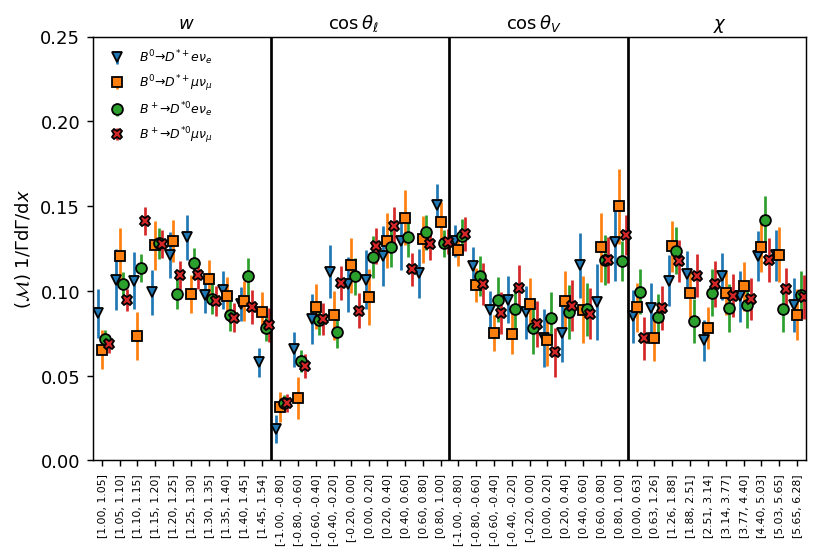

In [19]:
fig, ax = plt.subplots(dpi=130, figsize=(6.4, 4.4))
total_rate = {}

for i, channel in enumerate([15, 16, 17, 18]):

    result = data[channel]["data"][:40]
    
    ax.errorbar(
        x=[x +(0.2*i - 0.2) for x in range(0, 40)],
        y=unp.nominal_values(result),
        yerr=unp.std_devs(result),
        marker=markers[channel], ls="", markeredgecolor='black', label=channel_label[channel],
    )

make_plot_pretty(ax, bin_edges_all)
ax.set_ylim(0, 0.25)
ax.set_ylabel(r"$(\mathcal{M}$) $1 / \Gamma \mathrm{d} \Gamma / \mathrm{d}x$")

plt.tight_layout()
#plt.savefig(f"{plotoutdir}/acceptance_corrected_m_spectrum_normalized.pdf", transparent=True)
#plt.savefig(f"{plotoutdir}/acceptance_corrected_m_spectrum_normalized.png", transparent=True)   
plt.show()
plt.close()

In [20]:
shapes = fit_results[:160]
shapes_stat = fit_results_stat[:160]

In [21]:
for i in reversed(range(9, 160, 10)):
    shapes = np.delete(shapes, i)
    shapes_stat = np.delete(shapes_stat, i)

In [22]:
def get_average(chi2_average):
    m_average = Minuit(chi2_average, data[15]["central_fit"][:-1])
    m_average.migrad()  # run optimiser
    m_average.hesse()   # run covariance estimator
    return m_average

In [23]:
m = shapes
invC = scipy.linalg.inv(covariance_matrix(m))
def chi2_average(x):
    x_ = np.array((len(m) // 36) * [*x])
    delta = unp.nominal_values(m) - x_
    return delta @ invC @ delta
m_average = get_average(chi2_average)

m = shapes[:2*36]
invC = scipy.linalg.inv(covariance_matrix(m))
def chi2_average(x):
    x_ = np.array((len(m) // 36) * [*x])
    delta = unp.nominal_values(m) - x_
    return delta @ invC @ delta
m_Bzero_average = get_average(chi2_average)

m = shapes[2*36:]
invC = scipy.linalg.inv(covariance_matrix(m))
def chi2_average(x):
    x_ = np.array((len(m) // 36) * [*x])
    delta = unp.nominal_values(m) - x_
    return delta @ invC @ delta
m_Bplus_average = get_average(chi2_average)

m = np.array([*shapes[0:36], *shapes[2*36:3*36]])
invC = scipy.linalg.inv(covariance_matrix(m))
def chi2_average(x):
    x_ = np.array((len(m) // 36) * [*x])
    delta = unp.nominal_values(m) - x_
    return delta @ invC @ delta
m_electron_average = get_average(chi2_average)

m = np.array([*shapes[36:2*36], *shapes[3*36:]])
invC = scipy.linalg.inv(covariance_matrix(m))
def chi2_average(x):
    x_ = np.array((len(m) // 36) * [*x])
    delta = unp.nominal_values(m) - x_
    return delta @ invC @ delta
m_muon_average = get_average(chi2_average)

/tmp/ipykernel_58742/3721315730.py:3: IMinuitWarning: errordef not set, using 1 (appropriate for least-squares)
  m_average.migrad()  # run optimiser


In [24]:
m = shapes_stat
invC = scipy.linalg.inv(covariance_matrix(m))
def chi2_average(x):
    x_ = np.array((len(m) // 36) * [*x])
    delta = unp.nominal_values(m) - x_
    return delta @ invC @ delta
m_average_stat = get_average(chi2_average)

m = shapes_stat[:2*36]
invC = scipy.linalg.inv(covariance_matrix(m))
def chi2_average(x):
    x_ = np.array((len(m) // 36) * [*x])
    delta = unp.nominal_values(m) - x_
    return delta @ invC @ delta
m_Bzero_average_stat = get_average(chi2_average)

m = shapes_stat[2*36:]
invC = scipy.linalg.inv(covariance_matrix(m))
def chi2_average(x):
    x_ = np.array((len(m) // 36) * [*x])
    delta = unp.nominal_values(m) - x_
    return delta @ invC @ delta
m_Bplus_average_stat = get_average(chi2_average)

m = np.array([*shapes_stat[0:36], *shapes_stat[2*36:3*36]])
invC = scipy.linalg.inv(covariance_matrix(m))
def chi2_average(x):
    x_ = np.array((len(m) // 36) * [*x])
    delta = unp.nominal_values(m) - x_
    return delta @ invC @ delta
m_electron_average_stat = get_average(chi2_average)

m = np.array([*shapes_stat[36:2*36], *shapes_stat[3*36:]])
invC = scipy.linalg.inv(covariance_matrix(m))
def chi2_average(x):
    x_ = np.array((len(m) // 36) * [*x])
    delta = unp.nominal_values(m) - x_
    return delta @ invC @ delta
m_muon_average_stat = get_average(chi2_average)

/tmp/ipykernel_58742/3721315730.py:3: IMinuitWarning: errordef not set, using 1 (appropriate for least-squares)
  m_average.migrad()  # run optimiser


In [25]:
def get_full_spectrum(m):
    average = correlated_values(np.array(m.values), np.array(m.covariance))
    f0 = 1 - sum(average[ 0: 9])
    f1 = 1 - sum(average[ 9:18])
    f2 = 1 - sum(average[18:27])
    f3 = 1 - sum(average[27:36])
    return np.array([
        *average[ 0: 9], f0, 
        *average[ 9:18], f1, 
        *average[18:27], f2, 
        *average[27:36], f3, 
    ])

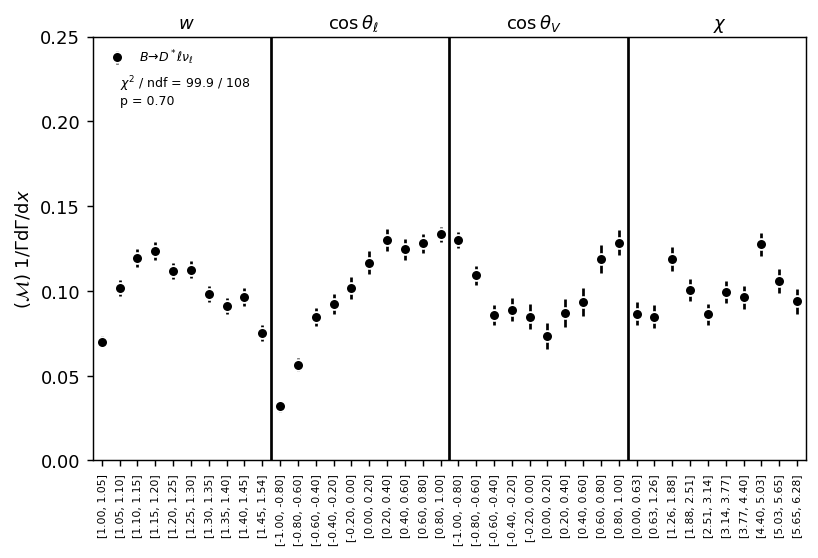

In [26]:
fig, ax = plt.subplots(dpi=130, figsize=(6.4, 4.4))

result = get_full_spectrum(m_average)
result_stat = get_full_spectrum(m_average_stat)

ax.errorbar(
    x=[x for x in range(0, 40)],
    y=unp.nominal_values(result),
    yerr=unp.std_devs(result),
    marker='o', color="black", ls="", markeredgecolor='white', label=r"$B \to D^* \ell \nu_\ell$",
)

# ax.errorbar(
#     x=[x for x in range(0, 40)],
#     y=unp.nominal_values(result_stat),
#     yerr=unp.std_devs(result_stat),
#     marker='.', color="tab:blue", ls="", markeredgecolor='white', label=r"$B \to D^* \ell \nu_\ell$",
# )


make_plot_pretty(ax, bin_edges_all)
ax.set_ylim(0, 0.25)
ax.set_ylabel(r"$(\mathcal{M}$) $1 / \Gamma \mathrm{d} \Gamma / \mathrm{d}x$")
ax.text(1, 0.22, f"$\chi^2$ / ndf = {m_average.fval:.1f} / {4*36-36}", size="x-small")
ax.text(1, 0.21, f"p = {scipy.stats.chi2.sf(m_average.fval, df=4*36-36):.2f}", size="x-small")
#ax.text(1, 0.18, f"$\chi^2$ / ndf = {m_average_stat.fval:.1f} / {4*36-36}", size="x-small")
#ax.text(1, 0.17, f"p = {scipy.stats.chi2.sf(m_average_stat.fval, df=4*36-36):.2f}", size="x-small")

plt.savefig(os.path.join(result_dir, "Average.pdf"), transparent=True)
plt.savefig(os.path.join(result_dir, "Average.png"), transparent=True) 
plt.tight_layout()
plt.show()
plt.close()

In [27]:
def chi2_table_columns(a, b, dof):
    return [
        f"{a.fval:.1f} / {dof}", 
        f"{scipy.stats.chi2.sf(a.fval, df=dof):.2f}", 
        f"{b.fval:.1f} / {dof}",
        f"{scipy.stats.chi2.sf(b.fval, df=dof):.2f}", 
    ]

In [28]:
table = pd.DataFrame.from_dict({
    channel_label["all"]: chi2_table_columns(m_average, m_average_stat, 3*36),
    channel_label["B0"]: chi2_table_columns(m_Bzero_average, m_Bzero_average_stat, 1*36),
    channel_label["B+"]: chi2_table_columns(m_Bplus_average, m_Bplus_average_stat, 1*36),
    channel_label["e"]: chi2_table_columns(m_electron_average, m_electron_average_stat, 1*36),
    channel_label["mu"]: chi2_table_columns(m_muon_average, m_muon_average_stat, 1*36),
}, columns=[r"$\chi^2$ / dof", "p", r"$\chi^2_\mathrm{stat}$ / dof", r"$p_\mathrm{stat}$"], orient="index")
table

,$\chi^2$ / dof,p,$\chi^2_\mathrm{stat}$ / dof,$p_\mathrm{stat}$
$B \to D^{*} \ell \nu_\ell$,99.9 / 108,0.70,104.6 / 108,0.57
$B^0 \to D^{*+} \ell \nu_\ell$,29.1 / 36,0.79,30.3 / 36,0.74
$B^+ \to D^{*0} \ell \nu_\ell$,26.3 / 36,0.88,27.3 / 36,0.85
"$B^{(0,+)} \to D^{*(+,0)} e \nu_e$",35.1 / 36,0.51,36.8 / 36,0.43
"$B^{(0,+)} \to D^{*(+,0)} \mu \nu_\mu$",42.7 / 36,0.21,44.2 / 36,0.16


In [29]:
table.to_latex(buf=os.path.join(result_dir, "Averages.tex"), escape=False)

In [30]:
average           = get_full_spectrum(m_average)
average_Bzero     = get_full_spectrum(m_Bzero_average)
average_Bplus     = get_full_spectrum(m_Bplus_average)
average_Belectron = get_full_spectrum(m_electron_average)
average_Bmuon     = get_full_spectrum(m_muon_average)

In [31]:
average_stat           = get_full_spectrum(m_average_stat)
average_Bzero_stat     = get_full_spectrum(m_Bzero_average_stat)
average_Bplus_stat     = get_full_spectrum(m_Bplus_average_stat)
average_Belectron_stat = get_full_spectrum(m_electron_average_stat)
average_Bmuon_stat     = get_full_spectrum(m_muon_average_stat)

In [32]:
def nice_output_transform(obs, obs_stat):
    return f"${obs.n:.3f} \pm {obs_stat.s:.3f} \pm {(obs.s**2 - obs_stat.s**2) ** 0.5:.3f}$"

In [33]:
R_Bzero = fit_results[-4] / fit_results[-3]
R_Bplus = fit_results[-2] / fit_results[-1]
R_B     = (fit_results[-4] + fit_results[-2]) / (fit_results[-1] + fit_results[-3])
Rs      = np.array([R_Bzero, R_Bplus, R_B])

In [34]:
R_Bzero_stat = fit_results_stat[-4] / fit_results_stat[-3]
R_Bplus_stat = fit_results_stat[-2] / fit_results_stat[-1]
R_B_stat     = (fit_results_stat[-4] + fit_results_stat[-2]) / (fit_results_stat[-1] + fit_results_stat[-3])
Rs_stat      = np.array([R_Bzero_stat, R_Bplus_stat, R_B_stat])

In [35]:
AFB_15 = sum(fit_results[0*40 + 15: 0*40 + 20]) - sum(fit_results[0*40 + 10:0*40 + 15])
AFB_16 = sum(fit_results[1*40 + 15: 1*40 + 20]) - sum(fit_results[1*40 + 10:1*40 + 15])
AFB_17 = sum(fit_results[2*40 + 15: 2*40 + 20]) - sum(fit_results[2*40 + 10:2*40 + 15])
AFB_18 = sum(fit_results[3*40 + 15: 3*40 + 20]) - sum(fit_results[3*40 + 10:3*40 + 15])
AFB_e = sum(average_Belectron[15:20]) - sum(average_Belectron[10:15])
AFB_mu = sum(average_Bmuon[15:20]) - sum(average_Bmuon[10:15])
AFBs = np.array([AFB_15, AFB_16, AFB_17, AFB_18, AFB_e, AFB_mu])

In [36]:
AFB_15_stat = sum(fit_results_stat[0*40 + 15: 0*40 + 20]) - sum(fit_results_stat[0*40 + 10:0*40 + 15])
AFB_16_stat = sum(fit_results_stat[1*40 + 15: 1*40 + 20]) - sum(fit_results_stat[1*40 + 10:1*40 + 15])
AFB_17_stat = sum(fit_results_stat[2*40 + 15: 2*40 + 20]) - sum(fit_results_stat[2*40 + 10:2*40 + 15])
AFB_18_stat = sum(fit_results_stat[3*40 + 15: 3*40 + 20]) - sum(fit_results_stat[3*40 + 10:3*40 + 15])
AFB_e_stat  = sum(average_Belectron_stat[15:20]) - sum(average_Belectron_stat[10:15])
AFB_mu_stat = sum(average_Bmuon_stat[15:20]) - sum(average_Bmuon_stat[10:15])
AFBs_stat   = np.array([AFB_15_stat, AFB_16_stat, AFB_17_stat, AFB_18_stat, AFB_e_stat, AFB_mu_stat])

In [37]:
deltaAFB_Bzero = AFB_16 - AFB_15
deltaAFB_Bplus = AFB_18 - AFB_17
deltaAFB_B     = AFB_mu - AFB_e
deltaAFBs      = np.array([deltaAFB_Bzero, deltaAFB_Bplus, deltaAFB_B])

In [38]:
deltaAFB_Bzero_stat = AFB_16_stat - AFB_15_stat
deltaAFB_Bplus_stat = AFB_18_stat - AFB_17_stat
deltaAFB_B_stat     = AFB_mu_stat - AFB_e_stat
deltaAFBs_stat      = np.array([deltaAFB_Bzero_stat, deltaAFB_Bplus_stat, deltaAFB_B_stat])

In [39]:
def predict_normalized_rate(F_L, l, u):
    return scipy.integrate.quad(lambda x: 1.5 * ((F_L * x**2) + 0.5 * (1 - F_L) * (1 - x**2)), l, u)[0]

def get_FL(cosVshape):
    cosVshape = cosVshape[:-1]
    C = statsmodels.stats.correlation_tools.cov_nearest(covariance_matrix(cosVshape), threshold=1e-3)
    invC = scipy.linalg.inv(C)
    bins = np.array([-1. , -0.8, -0.6, -0.4, -0.2,  0.,  0.2,  0.4,  0.6,  0.8,  1. ])[:-1]
    def chi2_FL(x):
        x_ = np.array([predict_normalized_rate(x, l, u) for l, u in zip(bins, bins[1:])])
        delta = unp.nominal_values(cosVshape) - x_
        return delta @ invC @ delta

    m_FL = Minuit(chi2_FL, 0)
    m_FL.migrad()  # run optimiser
    m_FL.hesse()   # run covariance estimator
    return m_FL

In [40]:
FL_15 = ufloat(np.array(get_FL(fit_results[0*40+20:0*40+30]).values), np.array(get_FL(fit_results[0*40+20:0*40+30]).covariance[0, 0]**0.5))
FL_16 = ufloat(np.array(get_FL(fit_results[1*40+20:1*40+30]).values), np.array(get_FL(fit_results[1*40+20:1*40+30]).covariance[0, 0]**0.5))
FL_17 = ufloat(np.array(get_FL(fit_results[2*40+20:2*40+30]).values), np.array(get_FL(fit_results[2*40+20:2*40+30]).covariance[0, 0]**0.5))
FL_18 = ufloat(np.array(get_FL(fit_results[3*40+20:3*40+30]).values), np.array(get_FL(fit_results[3*40+20:3*40+30]).covariance[0, 0]**0.5))
FL_e = ufloat(np.array(get_FL(average_Belectron[20:30]).values), np.array(get_FL(average_Belectron[20:30]).covariance[0, 0]**0.5))
FL_mu = ufloat(np.array(get_FL(average_Bmuon[20:30]).values), np.array(get_FL(average_Bmuon[20:30]).covariance[0, 0]**0.5))
FL_Bzero = ufloat(np.array(get_FL(average_Bzero[20:30]).values), np.array(get_FL(average_Bzero[20:30]).covariance[0, 0]**0.5))
FL_Bplus = ufloat(np.array(get_FL(average_Bplus[20:30]).values), np.array(get_FL(average_Bplus[20:30]).covariance[0, 0]**0.5))
FL = ufloat(np.array(get_FL(average[20:30]).values), np.array(get_FL(average[20:30]).covariance[0, 0]**0.5))
FLs = np.array([FL_15, FL_16, FL_17, FL_18, FL_e, FL_mu, FL_Bzero, FL_Bplus, FL])

/tmp/ipykernel_58742/1839046.py:15: IMinuitWarning: errordef not set, using 1 (appropriate for least-squares)
  m_FL.migrad()  # run optimiser


In [41]:
FL_15_stat = ufloat(np.array(get_FL(fit_results_stat[0*40+20:0*40+30]).values), np.array(get_FL(fit_results_stat[0*40+20:0*40+30]).covariance[0, 0]**0.5))
FL_16_stat = ufloat(np.array(get_FL(fit_results_stat[1*40+20:1*40+30]).values), np.array(get_FL(fit_results_stat[1*40+20:1*40+30]).covariance[0, 0]**0.5))
FL_17_stat = ufloat(np.array(get_FL(fit_results_stat[2*40+20:2*40+30]).values), np.array(get_FL(fit_results_stat[2*40+20:2*40+30]).covariance[0, 0]**0.5))
FL_18_stat = ufloat(np.array(get_FL(fit_results_stat[3*40+20:3*40+30]).values), np.array(get_FL(fit_results_stat[3*40+20:3*40+30]).covariance[0, 0]**0.5))
FL_e_stat = ufloat(np.array(get_FL(average_Belectron_stat[20:30]).values), np.array(get_FL(average_Belectron_stat[20:30]).covariance[0, 0]**0.5))
FL_mu_stat = ufloat(np.array(get_FL(average_Bmuon_stat[20:30]).values), np.array(get_FL(average_Bmuon_stat[20:30]).covariance[0, 0]**0.5))
FL_Bzero_stat = ufloat(np.array(get_FL(average_Bzero_stat[20:30]).values), np.array(get_FL(average_Bzero_stat[20:30]).covariance[0, 0]**0.5))
FL_Bplus_stat = ufloat(np.array(get_FL(average_Bplus_stat[20:30]).values), np.array(get_FL(average_Bplus_stat[20:30]).covariance[0, 0]**0.5))
FL_stat = ufloat(np.array(get_FL(average_stat[20:30]).values), np.array(get_FL(average_stat[20:30]).covariance[0, 0]**0.5))
FLs = np.array([FL_15_stat, FL_16_stat, FL_17_stat, FL_18_stat, FL_e_stat, FL_mu_stat, FL_Bzero_stat, FL_Bplus_stat, FL_stat])

/tmp/ipykernel_58742/1839046.py:15: IMinuitWarning: errordef not set, using 1 (appropriate for least-squares)
  m_FL.migrad()  # run optimiser


In [42]:
deltaFL_Bzero = FL_16 - FL_15
deltaFL_Bplus = FL_18 - FL_17
deltaFL_B     = FL_mu - FL_e
deltaFLs      = np.array([deltaFL_Bzero, deltaFL_Bplus, deltaFL_B])

In [43]:
deltaFL_Bzero_stat = FL_16_stat - FL_15_stat
deltaFL_Bplus_stat = FL_18_stat - FL_17_stat
deltaFL_B_stat     = FL_mu_stat - FL_e_stat
deltaFLs_stat      = np.array([deltaFL_Bzero_stat, deltaFL_Bplus_stat, deltaFL_B_stat])

In [44]:
table = {}
table[r"$F_L^{D^{*}}$"] = [
    nice_output_transform(FL_15, FL_15_stat), 
    nice_output_transform(FL_16, FL_16_stat), 
    nice_output_transform(FL_17, FL_17_stat), 
    nice_output_transform(FL_18, FL_18_stat),
    nice_output_transform(FL_e, FL_e_stat),
    nice_output_transform(FL_mu, FL_mu_stat),
    nice_output_transform(FL_Bzero, FL_Bzero_stat),
    nice_output_transform(FL_Bplus, FL_Bplus_stat),
    nice_output_transform(FL, FL_stat),
]
table = pd.DataFrame.from_dict(table, columns=[channel_label[channel] for channel in channels] + [channel_label["e"], channel_label["mu"], channel_label["B0"], channel_label["B+"], channel_label["all"]], orient="index").transpose()
table

,$F_L^{D^{*}}$
$B^0 \to D^{*+} e \nu_e$,$0.466 \pm 0.028 \pm 0.006$
$B^0 \to D^{*+} \mu \nu_\mu$,$0.475 \pm 0.027 \pm 0.004$
$B^+ \to D^{*0} e \nu_e$,$0.460 \pm 0.025 \pm 0.005$
$B^+ \to D^{*0} \mu \nu_\mu$,$0.481 \pm 0.024 \pm 0.004$
"$B^{(0,+)} \to D^{*(+,0)} e \nu_e$",$0.465 \pm 0.019 \pm 0.004$
"$B^{(0,+)} \to D^{*(+,0)} \mu \nu_\mu$",$0.482 \pm 0.018 \pm 0.003$
$B^0 \to D^{*+} \ell \nu_\ell$,$0.471 \pm 0.019 \pm 0.003$
$B^+ \to D^{*0} \ell \nu_\ell$,$0.470 \pm 0.018 \pm 0.003$
$B \to D^{*} \ell \nu_\ell$,$0.473 \pm 0.013 \pm 0.002$


In [45]:
table.to_latex(buf=os.path.join(result_dir, "FL.tex"), escape=False)

In [46]:
table = {}
table[r"$\Delta F_L^{D^{*}}$"] = [
    nice_output_transform(deltaFL_Bzero, deltaFL_Bzero_stat), 
    nice_output_transform(deltaFL_Bplus, deltaFL_Bplus_stat), 
    nice_output_transform(deltaFL_B, deltaFL_B_stat),
]
table = pd.DataFrame.from_dict(table, columns=[channel_label["B0"], channel_label["B+"], channel_label["all"]], orient="index").transpose()
table

,$\Delta F_L^{D^{*}}$
$B^0 \to D^{*+} \ell \nu_\ell$,$0.008 \pm 0.039 \pm 0.007$
$B^+ \to D^{*0} \ell \nu_\ell$,$0.022 \pm 0.035 \pm 0.007$
$B \to D^{*} \ell \nu_\ell$,$0.017 \pm 0.026 \pm 0.005$


In [47]:
table.to_latex(buf=os.path.join(result_dir, "DeltaFL.tex"), escape=False)

In [48]:
table = {}
table[r"$A_\mathrm{FB}$"] = [
    nice_output_transform(AFB_15, AFB_15_stat), 
    nice_output_transform(AFB_16, AFB_16_stat), 
    nice_output_transform(AFB_17, AFB_17_stat), 
    nice_output_transform(AFB_18, AFB_18_stat),
    nice_output_transform(AFB_e, AFB_e_stat),
    nice_output_transform(AFB_mu, AFB_mu_stat),
]
table = pd.DataFrame.from_dict(table, columns=[channel_label[channel] for channel in channels] + [channel_label["e"], channel_label["mu"]], orient="index").transpose()
table

,$A_\mathrm{FB}$
$B^0 \to D^{*+} e \nu_e$,$0.235 \pm 0.034 \pm 0.009$
$B^0 \to D^{*+} \mu \nu_\mu$,$0.280 \pm 0.035 \pm 0.006$
$B^+ \to D^{*0} e \nu_e$,$0.280 \pm 0.023 \pm 0.006$
$B^+ \to D^{*0} \mu \nu_\mu$,$0.269 \pm 0.023 \pm 0.005$
"$B^{(0,+)} \to D^{*(+,0)} e \nu_e$",$0.261 \pm 0.019 \pm 0.006$
"$B^{(0,+)} \to D^{*(+,0)} \mu \nu_\mu$",$0.271 \pm 0.019 \pm 0.004$


In [49]:
table.to_latex(buf=os.path.join(result_dir, "AFB.tex"), escape=False)

In [50]:
table = {}
table[r"$\Delta A_\mathrm{FB}$"] = [
    nice_output_transform(deltaAFB_Bzero, deltaAFB_Bzero_stat), 
    nice_output_transform(deltaAFB_Bplus, deltaAFB_Bplus_stat), 
    nice_output_transform(deltaAFB_B, deltaAFB_B_stat),
]
table = pd.DataFrame.from_dict(table, columns=[channel_label["B0"], channel_label["B+"], channel_label["all"]], orient="index").transpose()
table

,$\Delta A_\mathrm{FB}$
$B^0 \to D^{*+} \ell \nu_\ell$,$0.046 \pm 0.049 \pm 0.010$
$B^+ \to D^{*0} \ell \nu_\ell$,$-0.011 \pm 0.033 \pm 0.008$
$B \to D^{*} \ell \nu_\ell$,$0.010 \pm 0.027 \pm 0.007$


In [51]:
table.to_latex(buf=os.path.join(result_dir, "DeltaAFB.tex"), escape=False)

In [52]:
table = {}
table[r"$R_{{e\mu}}$"] = [
    nice_output_transform(R_Bzero, R_Bzero_stat), 
    nice_output_transform(R_Bplus, R_Bplus_stat), 
    nice_output_transform(R_B    , R_B_stat),
]
table = pd.DataFrame.from_dict(table, columns=[channel_label["B0"], channel_label["B+"], channel_label["all"]], orient="index").transpose()
table

,$R_{{e\mu}}$
$B^0 \to D^{*+} \ell \nu_\ell$,$0.988 \pm 0.039 \pm 0.025$
$B^+ \to D^{*0} \ell \nu_\ell$,$0.967 \pm 0.026 \pm 0.022$
$B \to D^{*} \ell \nu_\ell$,$0.977 \pm 0.023 \pm 0.023$


In [53]:
table.to_latex(buf=os.path.join(result_dir, "Remu.tex"), escape=False)

In [54]:
def predict_normalized_rate_smooth(F_L, x):
    return 1.5 * ((F_L * x**2) + 0.5 * (1 - F_L) * (1 - x**2))

In [55]:
m_FL = get_FL(average[20:30])

FL = ufloat(np.array([m_FL.values]), np.array([m_FL.covariance[0, 0]**0.5]))
#FL_SM = ufloat(0.517, 0.005)

/tmp/ipykernel_58742/1839046.py:15: IMinuitWarning: errordef not set, using 1 (appropriate for least-squares)
  m_FL.migrad()  # run optimiser


In [56]:
tmp = np.array([rate_lattice.DGamma_DcosV(lower, upper) / rate_lattice.Gamma() for lower, upper in zip(bin_edges_all["costhetavReco"], bin_edges_all["costhetavReco"][1:])])
m_FL_lattice = get_FL(tmp)
FL_lattice = ufloat(np.array([m_FL_lattice.values]), np.array([m_FL_lattice.covariance[0, 0]**0.5]))

/tmp/ipykernel_58742/1839046.py:15: IMinuitWarning: errordef not set, using 1 (appropriate for least-squares)
  m_FL.migrad()  # run optimiser


In [57]:
tension = (FL - FL_lattice)
tension.n / tension.s

0.16882426387746136

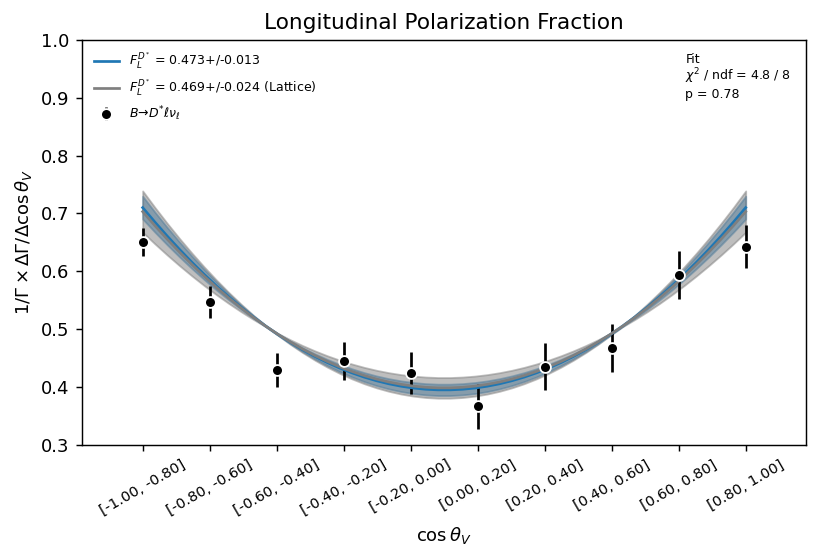

In [58]:
fig, ax = plt.subplots(dpi=130, figsize=(6.4, 4.4)) 
    
ax.errorbar(
    x=np.linspace(-1, 1, num=10),
    y=unp.nominal_values(average[20:30]) / 0.2,  # Divide by bin width because we measured integrals
    yerr=unp.std_devs(average[20:30]) / 0.2,
    ls="", marker="o", markeredgecolor="white", color="black", label=channel_label["all"]
)

tmp = predict_normalized_rate_smooth(FL, np.linspace(-1, 1))
ax.plot(np.linspace(-1, 1), unp.nominal_values(tmp), color="tab:blue", label=f"$F_L^{{D^*}}$ = {FL:.3f}")
ax.fill_between(
    np.linspace(-1, 1), 
    unp.nominal_values(tmp) - unp.std_devs(tmp),
    unp.nominal_values(tmp) + unp.std_devs(tmp),
    alpha=0.5, color="tab:blue"
)

tmp = predict_normalized_rate_smooth(FL_lattice, np.linspace(-1, 1))
ax.plot(np.linspace(-1, 1), unp.nominal_values(tmp), color="tab:grey", label=f"$F_L^{{D^*}}$ = {FL_lattice:.3f} (Lattice)")
ax.fill_between(
    np.linspace(-1, 1), 
    unp.nominal_values(tmp) - unp.std_devs(tmp),
    unp.nominal_values(tmp) + unp.std_devs(tmp),
    alpha=0.5, color="tab:grey"
)

ax.set_xlim(-1.2, 1.2)
ax.set_ylim(0.3, 1.0)
ax.set_xlabel(r"$\cos \theta_V$")
ax.set_ylabel(r"$1/\Gamma \times \Delta \Gamma / \Delta \cos \theta_V$")
ax.set_xticks(np.linspace(-1, 1, num=10))
ax.set_xticklabels([f"[{lower:.2f}, {upper:.2f}]" for lower, upper in zip(bin_edges_all["costhetavReco"], bin_edges_all["costhetavReco"][1:])], rotation=30, fontsize=8)

#make_plot_pretty(ax, bin_edges_all)
#ax.set_ylim(0.18, 0.42)
ax.legend(frameon=False, fontsize="x-small", ncol=1, loc='upper left')

ax.set_title("Longitudinal Polarization Fraction")

ax.text(0.8, 0.96, f"Fit", size="x-small")
ax.text(0.8, 0.93, f"$\chi^2$ / ndf = {m_FL.fval:.1f} / 8", size="x-small")
ax.text(0.8, 0.90, f"p = {scipy.stats.chi2.sf(m_FL.fval, df=8):.2f}", size="x-small")

#plt.text(2, 1.02, "Preliminary", size=50,
#         ha="right", va="top",
#         bbox=dict(boxstyle="square",
#                   ec=(1., 0.5, 0.5),
#                   fc=(1., 0.8, 0.8),
#                   alpha=0.3
#                   )
#         )

plt.tight_layout()
plt.savefig(os.path.join(result_dir, "FLFit.pdf"), transparent=True)
plt.savefig(os.path.join(result_dir, "FLFit.png"), transparent=True) 
plt.show()
plt.close()

No handles with labels found to put in legend.
/tmp/ipykernel_58742/2764651503.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


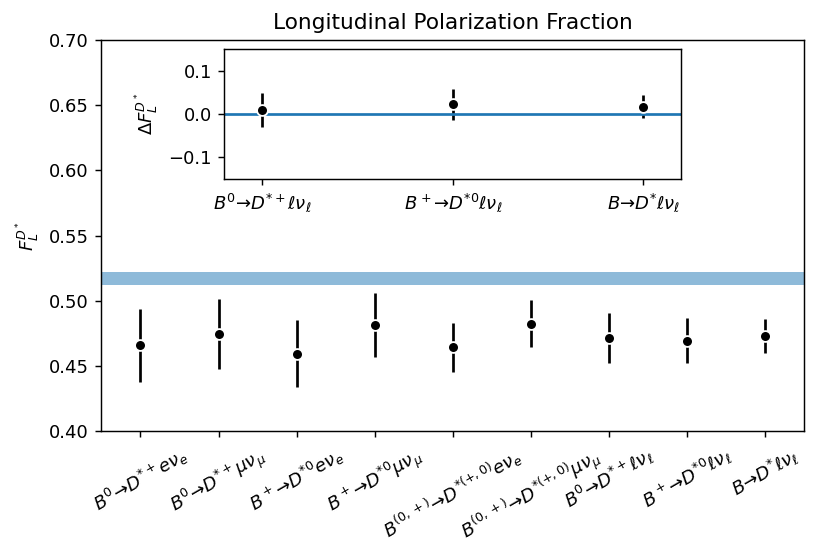

In [59]:
fig, ax = plt.subplots(dpi=130, figsize=(6.4, 4.4))   

ax.errorbar(
    x=range(9),
    y=unp.nominal_values(FLs),
    yerr=unp.std_devs(FLs),
    ls="", marker="o", markeredgecolor="white", color="black"
)

#ax.axhline(0.517, color="tab:blue")
ax.fill_between(np.linspace(-0.5, 9.5), 0.517-0.005, 0.517+0.005, alpha=0.5)

#ax.fill_between(
#    np.linspace(-0.5, 5.5),
#    (rate[15].DGamma_DcosL(0, 1) - rate[15].DGamma_DcosL(-1, 0)) / (rate[15].DGamma_DcosL(0, 1) + rate[15].DGamma_DcosL(-1, 0)),
#    (rate[17].DGamma_DcosL(0, 1) - rate[17].DGamma_DcosL(-1, 0)) / (rate[17].DGamma_DcosL(0, 1) + rate[17].DGamma_DcosL(-1, 0)),
#    color="black", alpha=0.5, 
#    )

#make_plot_pretty(ax, bin_edges_all)
ax.set_ylabel("$F_L^{D^*}$")
ax.set_xlim(-0.5, 8.5)
ax.set_ylim(0.4, 0.7)
ax.legend(frameon=False, fontsize="x-small", ncol=1, loc='upper left')
ax.set_xticks(range(0, 9))
ax.set_xticklabels([channel_label[channel] for channel in channels] + [channel_label["e"], channel_label["mu"], channel_label["B0"], channel_label["B+"], channel_label["all"]], rotation=30)

parent_axes = plt.gca()
inside_axis = inset_axes(parent_axes,
                    width="65%", # width = 30% of parent_bbox
                    height=1, # height : 1 inch
                    loc="upper center")

inside_axis.errorbar(
    x=range(3),
    y=unp.nominal_values(deltaFLs),
    yerr=unp.std_devs(deltaFLs),
    ls="", marker="o", markeredgecolor="white", color="black"
)
inside_axis.axhline(0.0, color="tab:blue")

inside_axis.set_xlim(-0.2, 2.2)
inside_axis.set_ylim(-0.15, 0.15)
inside_axis.set_ylabel("$\Delta F_L^{D^*}$")# = F_L^{D^*\mu} - F_L^{D^*e}$")
inside_axis.set_xticks(range(0, 3))
inside_axis.set_xticklabels([channel_label[channel] for channel in ["B0", "B+", "all"]])

ax.set_title("Longitudinal Polarization Fraction")

#plt.text(1.5, 0., "Preliminary", size=50, rotation=-25.,
#         ha="right", va="top",
#         bbox=dict(boxstyle="square",
#                   ec=(1., 0.5, 0.5),
#                   fc=(1., 0.8, 0.8),
#                   alpha=0.3
#                   )
#         )

plt.tight_layout()
plt.savefig(os.path.join(result_dir, "FL.pdf"), transparent=True)
plt.savefig(os.path.join(result_dir, "FL.png"), transparent=True) 
plt.show()
plt.close()

No handles with labels found to put in legend.
/tmp/ipykernel_58742/3681060629.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


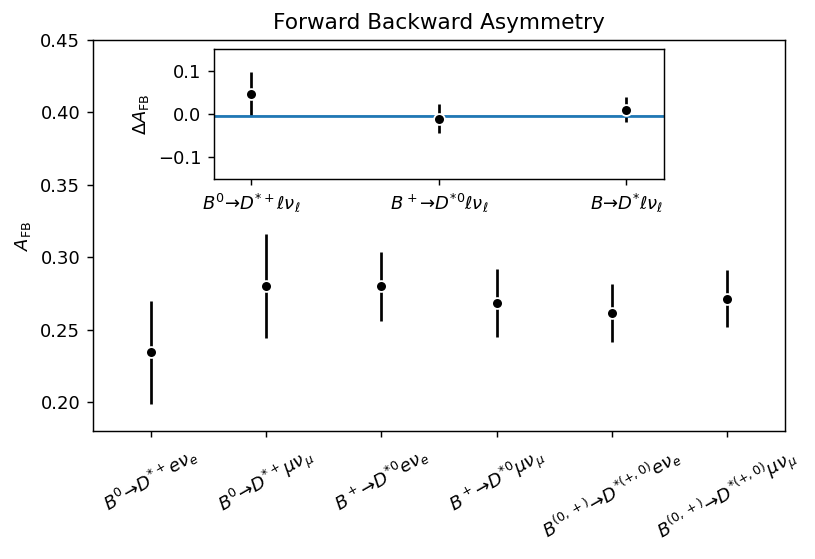

In [60]:
fig, ax = plt.subplots(dpi=130, figsize=(6.4, 4.4))   

ax.errorbar(
    x=range(6),
    y=unp.nominal_values(AFBs),
    yerr=unp.std_devs(AFBs),
    ls="", marker="o", markeredgecolor="white", color="black"
)

#ax.fill_between(
#    np.linspace(-0.5, 5.5),
#    (rate[15].DGamma_DcosL(0, 1) - rate[15].DGamma_DcosL(-1, 0)) / (rate[15].DGamma_DcosL(0, 1) + rate[15].DGamma_DcosL(-1, 0)),
#    (rate[17].DGamma_DcosL(0, 1) - rate[17].DGamma_DcosL(-1, 0)) / (rate[17].DGamma_DcosL(0, 1) + rate[17].DGamma_DcosL(-1, 0)),
#    color="black", alpha=0.5, 
#    )

#make_plot_pretty(ax, bin_edges_all)
ax.set_ylabel("$A_\mathrm{FB}$")
ax.set_xlim(-0.5, 5.5)
ax.set_ylim(0.18, 0.45)
ax.legend(frameon=False, fontsize="x-small", ncol=1, loc='upper left')
ax.set_xticks(range(0, 6))
ax.set_xticklabels([channel_label[channel] for channel in channels] + [channel_label["e"], channel_label["mu"]], rotation=30)

parent_axes = plt.gca()
inside_axis = inset_axes(parent_axes,
                    width="65%", # width = 30% of parent_bbox
                    height=1, # height : 1 inch
                    loc="upper center")

inside_axis.errorbar(
    x=range(3),
    y=unp.nominal_values(deltaAFBs),
    yerr=unp.std_devs(deltaAFBs),
    ls="", marker="o", markeredgecolor="white", color="black"
)
inside_axis.axhline(-5.33e-3, color="tab:blue")
inside_axis.fill_between(np.linspace(-0.2, 2.2), -5.33e-3 + 0.25e-3, -5.33e-3 - 0.25e-3, color="tab:blue", alpha=0.5)

inside_axis.set_xlim(-0.2, 2.2)
inside_axis.set_ylim(-0.15, 0.15)
inside_axis.set_ylabel("$\Delta A_\mathrm{FB}$")# = A_\mathrm{FB}^\mu - A_\mathrm{FB}^e$")
inside_axis.set_xticks(range(0, 3))
inside_axis.set_xticklabels([channel_label[channel] for channel in ["B0", "B+", "all"]])

ax.set_title("Forward Backward Asymmetry")

#plt.text(1.5, 0., "Preliminary", size=50, rotation=-25.,
#         ha="right", va="top",
#         bbox=dict(boxstyle="square",
#                   ec=(1., 0.5, 0.5),
#                   fc=(1., 0.8, 0.8),
#                   alpha=0.3
#                   )
#         )

plt.tight_layout()
plt.savefig(os.path.join(result_dir, "AFB.pdf"), transparent=True)
plt.savefig(os.path.join(result_dir, "AFB.png"), transparent=True) 
plt.show()
plt.close()

No handles with labels found to put in legend.


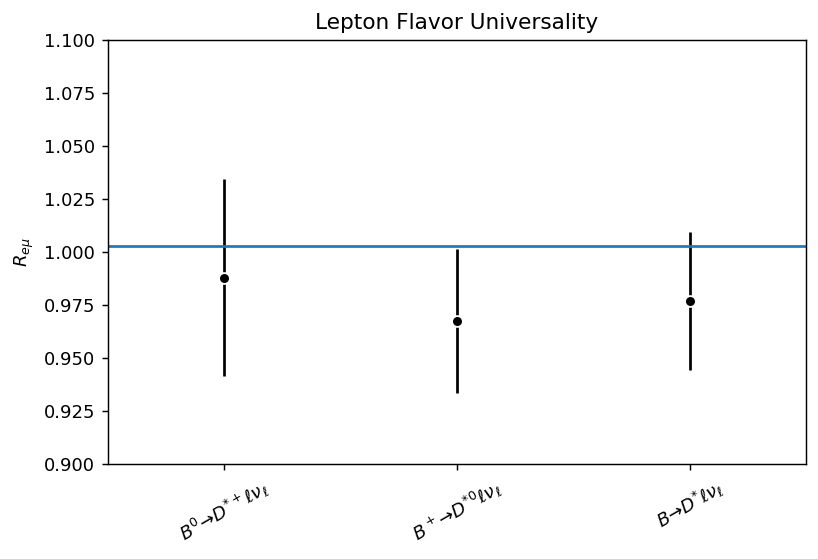

In [61]:
fig, ax = plt.subplots(dpi=130, figsize=(6.4, 4.4))   
    
ax.errorbar(
    x=range(3),
    y=unp.nominal_values(Rs),
    yerr=unp.std_devs(Rs),
    ls="", marker="o", markeredgecolor="white", color="black"
)
ax.axhline(1.0026, color="tab:blue")
ax.fill_between(np.linspace(-0.2, 2.2), 1.0026 + 0.0001, 1.0026 - 0.0001, alpha=0.5)


ax.set_xlim(-0.2, 2.2)
ax.set_ylim(0.9, 1.1)
ax.set_ylabel("$\Delta A_\mathrm{FB} = A_\mathrm{FB}^\mu - A_\mathrm{FB}^e$")
ax.set_xticks(range(0, 3))
ax.set_xticklabels([channel_label[channel] for channel in ["B0", "B+", "all"]], rotation=30)

#make_plot_pretty(ax, bin_edges_all)
ax.set_ylabel("$R_{e\mu}$")
ax.set_xlim(-0.5, 2.5)
#ax.set_ylim(0.18, 0.42)
ax.legend(frameon=False, fontsize="x-small", ncol=1, loc='upper left')

ax.set_title("Lepton Flavor Universality")

#plt.text(2, 1.02, "Preliminary", size=50,
#         ha="right", va="top",
#         bbox=dict(boxstyle="square",
#                   ec=(1., 0.5, 0.5),
#                   fc=(1., 0.8, 0.8),
#                   alpha=0.3
#                   )
#         )

plt.tight_layout()
plt.savefig(os.path.join(result_dir, "Remu.pdf"), transparent=True)
plt.savefig(os.path.join(result_dir, "Remu.png"), transparent=True) 
plt.show()
plt.close()

#### Fit Matrix

- [x] Data Only Fits with BGL and CLN to study the data (stat. only)
    - [x] Each channel 
    - [x] Average B+ channels 
    - [x] Average B0 channels 
    - [x] Average all channels 
    - [x] Average e and mu channels 
- [ ] Data Only Fits with BGL and CLN to study the data (stat. + sys.)
- [ ] Average spectrum / fit all 
    - [ ] Nested hypothesis test for number of coefficients to determine number of BGL coefficients
    - [ ] Include theory constraints into Chi2 Function, Vcb as free parameter, eta_ew as correct value https://arxiv.org/pdf/2105.14019.pdf, data in arxiv available. Bad chi2 expected
      - [ ] BGL paramter directly as "nuisance" constraints 
      - [x] h_A1(1)
      - [x] h_A1(1.03), h_A1(1.1), h_A1(1.17) available in auxilary files, correlation!
      - [ ] add h_V, h_A2, h_A3 --> this needs implementation in effort2

In [62]:
hA1, hA1_2014

(0.9093530544721915+/-0.0168300891396001, 0.906+/-0.012649110640673518)

In [63]:
def theory_term_cln_disabled(rate, *x):
    return 0

def theory_term_cln_A(rate, *x):
    rate_cln[channel].Vcb = x[4]
    rate_cln[channel].FF.rho2 = x[0]
    rate_cln[channel].FF.R1_1 = x[1]
    rate_cln[channel].FF.R2_1 = x[2]
    rate_cln[channel].FF.h_A1_1 = x[3]
    return (rate.FF.h_A1(1.0) - hA1.nominal_value) ** 2 / hA1.std_dev ** 2

def theory_term_cln_A2014(rate, *x):
    rate_cln[channel].Vcb = x[4]
    rate_cln[channel].FF.rho2 = x[0]
    rate_cln[channel].FF.R1_1 = x[1]
    rate_cln[channel].FF.R2_1 = x[2]
    rate_cln[channel].FF.h_A1_1 = x[3]
    return (rate.FF.h_A1(1.0) - hA1_2014.nominal_value) ** 2 / hA1_2014.std_dev ** 2

def theory_term_cln_B(rate, *x):
    rate_cln[channel].Vcb = x[4]
    rate_cln[channel].FF.rho2 = x[0]
    rate_cln[channel].FF.R1_1 = x[1]
    rate_cln[channel].FF.R2_1 = x[2]
    rate_cln[channel].FF.h_A1_1 = x[3]
    delta = np.array([rate.FF.h_A1(1.03), rate.FF.h_A1(1.10), rate.FF.h_A1(1.17)]) - unp.nominal_values(hA1_all)
    return delta @ np.linalg.inv(covariance_matrix(hA1_all)) @ delta

In [64]:
def theory_term_bgl_disabled(rate, *x):
    return 0

def theory_term_bgl_A(rate, *x):
    rate.Vcb = x[9]
    rate.FF.set_expansion_coefficients(x[:3], x[3:6], x[6:9])
    return (rate.FF.h_A1(1.0) - hA1.nominal_value) ** 2 / hA1.std_dev ** 2

def theory_term_bgl_A2014(rate, *x):
    rate.Vcb = x[9]
    rate.FF.set_expansion_coefficients(x[:3], x[3:6], x[6:9])
    return (rate.FF.h_A1(1.0) - hA1_2014.nominal_value) ** 2 / hA1_2014.std_dev ** 2

def theory_term_bgl_B(rate, *x):
    rate.Vcb = x[9]
    rate.FF.set_expansion_coefficients(x[:3], x[3:6], x[6:9])
    delta = np.array([rate.FF.h_A1(1.03), rate.FF.h_A1(1.10), rate.FF.h_A1(1.17)]) - unp.nominal_values(hA1_all)
    return delta @ np.linalg.inv(covariance_matrix(hA1_all)) @ delta

In [65]:
fit_spectrum = correlated_values(np.array(m_average.values), np.array(m_average.covariance))
fit_spectrum_values = np.array(m_average.values)
fit_spectrum_Cinv = np.linalg.inv(np.array(m_average.covariance))

theory_term_cln = theory_term_cln_A2014# B_cln#A2014_cln
theory_term_bgl = theory_term_bgl_A2014# B#A2014

a = 1
b = 2
c = 2
#test = np.array([ 0.01280254,  0.52435934,  0. ,  0.01319078, -0.0046844 , 0. , -0.00571301,  0.,  0., 1])
test = np.array([1.05372e-03, 0, 0, 5.15243e-04, -3.02666e-04, 0, -5.10685e-05, 0, 0 ]) / 39.1214e-3 / 1.0066
test_err = np.array([ 6.66143e-05, 1.98470e-05, 8.03393e-04, 7.49446e-05]) / 39.1214e-3 / 1.0066

In [66]:
def chi2_normalized_minuit_cln(rho2, R1_1, R2_1, h_A1_1):
    Vcb = 1
    delta = fit_spectrum_values - transform(drop(theory_normalized_cln(np.array([rho2, R1_1, R2_1, h_A1_1, Vcb]), "B0")))[:-1]
    chi2 = 0
    chi2 += delta @ fit_spectrum_Cinv @ delta 
    chi2 += theory_term_cln(rate_cln["B0"], rho2, R1_1, R2_1, h_A1_1, Vcb)
    return chi2

m_cln = Minuit(chi2_normalized_minuit_cln, 
           rho2 = 1.03,
           R1_1 = 1.38,
           R2_1 = 0.97,
           h_A1_1 = 0.906
          )

m_cln.simplex()
m_cln.migrad()  # run optimiser
m_cln.hesse()   # run covariance estimator
m_cln

/tmp/ipykernel_58742/2910696798.py:16: IMinuitWarning: errordef not set, using 1 (appropriate for least-squares)
  m_cln.simplex()


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 63.23                      │              Nfcn = 132              │
│ EDM = 1.16e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ rho2   │   1.35    │   0.09    │            │            │         │         │       │
│ 1 │ R1_1   │   1.52    │   0.09    │            │            │         │         │       │
│ 2 │ R2_1   │   0.89    │   0.07    │            │            │         │         │       │
│ 3 │ h_A1_1 │   0.906   │   0.009   │            │            │         │         │  yes  │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────────┐
│        │     rho2     R1_1     R2_1   h_A1_1 │
├────────┼─────────────────────────────────────┤
│   rho2 │  0.00755   0.0044 -0.00537        0 │
│   R1_1 │   0.0044  0.00784 -0.00416        0 │
│   R2_1 │ -0.00537 -0.00416  0.00502        0 │
│ h_A1_1 │        0        0        0        0 │
└────────┴─────────────────────────────────────┘

In [67]:
def chi2_normalized_minuit_bgl(a0, a1, a2, b0, b1, b2, c1, c2, c3):
    Vcb = 1
    delta = fit_spectrum_values - transform(drop(theory_normalized(np.array([a0, a1, a2, b0, b1, b2, c1, c2, c3, Vcb]), "B0")))[:-1]
    chi2 = 0
    chi2 += delta @ fit_spectrum_Cinv @ delta 
    chi2 += theory_term_bgl(rate["B0"], a0, a1, a2, b0, b1, b2, c1, c2, c3, Vcb)
    return chi2

m_bgl = Minuit(chi2_normalized_minuit_bgl, 
   a0=test[0] if a >= 1 else 0,
   a1=test[1] if a >= 2 else 0,
   a2=0,
   b0=test[2] if b >= 1 else 0,
   b1=test[3] if b >= 2 else 0,
   b2=0,
   c1=test[4] if c >= 1 else 0,
   c2=0,
   c3=0
  )

m_bgl.fixed["a0"] = True if a <= 0 else False
m_bgl.fixed["b0"] = True if b <= 0 else False
m_bgl.fixed["c1"] = True if c <= 0 else False

m_bgl.fixed["a1"] = True if a <= 1 else False
m_bgl.fixed["b1"] = True if b <= 1 else False
m_bgl.fixed["c2"] = True if c <= 1 else False

m_bgl.fixed["a2"] = True if a <= 2 else False
m_bgl.fixed["b2"] = True if b <= 2 else False
m_bgl.fixed["c3"] = True if c <= 2 else False

#m_bgl.limits["b0"] = (1e-6, None)

# m_bgl.limits["a0"] = (-100, 100)
# m_bgl.limits["a1"] = (-100, 100)
# m_bgl.limits["a2"] = (-100, 100)
# m_bgl.limits["b0"] = (1e-6, 100)
# m_bgl.limits["b1"] = (-100, 100)
# m_bgl.limits["b2"] = (-100, 100)
# m_bgl.limits["c1"] = (-100, 100)
# m_bgl.limits["c2"] = (-100, 100)
# m_bgl.limits["c3"] = (-100, 100)

#m_bgl.limits["a0"] = (test[0] - 5*test_err[0], test[0] + 5*test_err[0])
#m_bgl.limits["b0"] = (test[3] - 5*test_err[1], test[3] + 5*test_err[1])
#m_bgl.limits["b1"] = (test[4] - 5*test_err[2], test[4] + 5*test_err[2])
#m_bgl.limits["c1"] = (test[6] - 5*test_err[3], test[6] + 5*test_err[3])

m_bgl.simplex()
m_bgl.migrad()  # run optimiser
m_bgl.hesse()   # run covariance estimator
m_bgl

/tmp/ipykernel_58742/80227764.py:50: IMinuitWarning: errordef not set, using 1 (appropriate for least-squares)
  m_bgl.simplex()


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 38.43                      │              Nfcn = 270              │
│ EDM = 4.32e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a0   │  0.0313   │  0.0017   │            │            │         │         │       │
│ 1 │ a1   │    0.0    │    0.1    │            │            │         │         │  yes  │
│ 2 │ a2   │    0.0    │    0.1    │            │            │         │         │  yes  │
│ 3 │ b0   │ 12.24e-3  │  0.17e-3  │            │            │         │         │       │
│ 4 │ b1   │  -0.043   │   0.012   │            │            │         │         │       │
│ 5 │ b2   │    0.0    │    0.1    │            │            │         │         │  yes  │
│ 6 │ c1   │  -0.021   │   0.004   │            │            │         │         │       │
│ 7 │ c2   │   0.33    │   0.08    │            │            │         │         │       │
│ 8 │ c3   │    0.0    │    0.1    │            │            │         │         │  yes  │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────────────────────────────────────────────────────────────────────────────┐
│    │        a0        a1        a2        b0        b1        b2        c1        c2        c3 │
├────┼───────────────────────────────────────────────────────────────────────────────────────────┤
│ a0 │  2.76e-06         0         0  7.47e-08 -5.64e-06         0  1.68e-06 -2.74e-05         0 │
│ a1 │         0         0         0         0         0         0         0         0         0 │
│ a2 │         0         0         0         0         0         0         0         0         0 │
│ b0 │  7.47e-08         0         0  2.92e-08 -1.03e-07         0 -4.97e-08  7.92e-07         0 │
│ b1 │ -5.64e-06         0         0 -1.03e-07   0.00014         0   6.7e-06 -8.63e-05         0 │
│ b2 │         0         0         0         0         0         0         0         0         0 │
│ c1 │  1.68e-06         0         0 -4.97e-08   6.7e-06         0  1.56e-05 -0.000298         0 │
│ c2 │ -2.74e-05         0         0  7.92e-07 -8.63e-05         0 -0.000298   0.00595         0 │
│ c3 │         0         0         0         0         0         0         0         0         0 │
└────┴───────────────────────────────────────────────────────────────────────────────────────────┘

In [68]:
coefficients_bgl = np.array(correlated_values(np.array(m_bgl.values), np.array(m_bgl.covariance)))
coefficients_cln = np.array(correlated_values(np.array(m_cln.values), np.array(m_cln.covariance)))

In [69]:
def parse_bgl(c):
    corr = correlation_matrix(c)
    values = c
    index_picks = [0, 1, 2, 3, 4, 5, 6, 7]
    return pd.DataFrame.from_dict({
        r"$a_0$": [values[0]*1e2, *[corr[0, i] for i in index_picks]],
        r"$a_1$": [values[1]*1e2, *[corr[1, i] for i in index_picks]],
        r"$a_2$": [values[2]*1e2, *[corr[2, i] for i in index_picks]],
        r"$b_0$": [values[3]*1e2, *[corr[3, i] for i in index_picks]],
        r"$b_1$": [values[4]*1e2, *[corr[4, i] for i in index_picks]],
        r"$b_2$": [values[5]*1e2, *[corr[5, i] for i in index_picks]],
        r"$c_1$": [values[6]*1e2, *[corr[6, i] for i in index_picks]],
        r"$c_2$": [values[7]*1e2, *[corr[7, i] for i in index_picks]],
    }, columns=["Value x10", "Correlation", "", "", "", "", "", "", ""], orient="index").applymap(lambda x: f"{x:.2f}")

table = parse_bgl(coefficients_bgl)
table

/home/mapr/projects/eFFORT2/venv/lib/python3.8/site-packages/uncertainties/core.py:2953: RuntimeWarning: invalid value encountered in true_divide
  return cov_mat/std_devs/std_devs[numpy.newaxis].T


,Value x10,Correlation,,,,,,,
$a_0$,3.13+/-0.17,1.00,nan,nan,0.26,-0.29,nan,0.26,-0.21
$a_1$,0.00+/-0,nan,nan,nan,nan,nan,nan,nan,nan
$a_2$,0.00+/-0,nan,nan,nan,nan,nan,nan,nan,nan
$b_0$,1.22+/-0.02,0.26,nan,nan,1.00,-0.05,nan,-0.07,0.06
$b_1$,-4.30+/-1.18,-0.29,nan,nan,-0.05,1.00,nan,0.14,-0.09
$b_2$,0.00+/-0,nan,nan,nan,nan,nan,nan,nan,nan
$c_1$,-2.09+/-0.39,0.26,nan,nan,-0.07,0.14,nan,1.00,-0.98
$c_2$,33.22+/-7.71,-0.21,nan,nan,0.06,-0.09,nan,-0.98,1.00


In [70]:
table.to_latex(buf=os.path.join(result_dir, f"BGL{a}{b}{c}.tex"), escape=False)

In [71]:
def parse_cln(c):
    corr = correlation_matrix(c)
    values = c
    
    return pd.DataFrame.from_dict({
        r"$\rho_2$": [values[0], *corr[0, :]],
        r"$R_1(1)$": [values[1], *corr[1, :]],
        r"$R_2(1)$": [values[2], *corr[2, :]],
        r"$h_{A_1}(1)$": [c[3], *corr[3, :]],
    }, columns=["Value", "Correlation", "", "", ""], orient="index").applymap(lambda x: f"{x:.2f}")

table = parse_cln(coefficients_cln)
table

/home/mapr/projects/eFFORT2/venv/lib/python3.8/site-packages/uncertainties/core.py:2953: RuntimeWarning: invalid value encountered in true_divide
  return cov_mat/std_devs/std_devs[numpy.newaxis].T


,Value,Correlation,,,
$\rho_2$,1.35+/-0.09,1.00,0.57,-0.87,nan
$R_1(1)$,1.52+/-0.09,0.57,1.00,-0.66,nan
$R_2(1)$,0.89+/-0.07,-0.87,-0.66,1.00,nan
$h_{A_1}(1)$,0.91+/-0,nan,nan,nan,nan


In [72]:
table.to_latex(buf=os.path.join(result_dir, "CLN.tex"), escape=False)

In [73]:
#coefficients_bgl = np.array([
#    0.00105402, 0, 0, 
#    0.000503575, -0.000303081, 0,
#    -5.24981e-05, 0, 0
#])

In [74]:
#coefficients_bgl = np.array([
#    0.00105402, 0, 0, 
#    0.000503575, -0.000303081, 0,
#    -5.24981e-05, 0, 0
#])

bToDStarBGL = BToDStarBGL(
    m_B=5.27963,
    m_V=2.01026,
    #m_B=5.280,
    #m_V=2.010,
    exp_coeff_a = coefficients_bgl[0:3],
    exp_coeff_b = coefficients_bgl[3:6],
    exp_coeff_c = coefficients_bgl[6:9],
    chiT_plus33 = 5.131e-4,
    chiT_minus33 = 3.894e-4,
    axialvector_poles = [6.739, 6.750, 7.145, 7.150],
    vector_poles = [6.329, 6.920, 7.020], 
)

#rate_bgl = BtoV(bToDStarBGL, Vcb=1, eta_EW=1)
rate_bgl = BtoV(bToDStarBGL, Vcb=1)


bToDStarCLN = BToDStarCLN(
    m_B=m_Bzero,
    m_V=m_Dstarplus,
    h_A1_1 = coefficients_cln[3],
    rho2 = coefficients_cln[0],
    R1_1 = coefficients_cln[1],
    R2_1 = coefficients_cln[2],
)

rate_cln = BtoV(bToDStarCLN, 1)

In [75]:
w=1.05
print("With new chi and pole masses:")
print(f"f(w={w}) = {rate_bgl.FF.f(rate_bgl.FF.z(w)):.5f}")
print(f"g(w={w}) = {rate_bgl.FF.g(rate_bgl.FF.z(w)):.5f}")
print(f"F1(w={w}) = {rate_bgl.FF.F1(rate_bgl.FF.z(w)):.5f}")
print(f"H+(w={w}) = {rate_bgl.FF.Hplus(w):.5f}")
print(f"H-(w={w}) = {rate_bgl.FF.Hminus(w):.5f}")
print(f"H0(w={w}) = {rate_bgl.FF.Hzero(w):.5f}")

With new chi and pole masses:
f(w=1.05) = 5.57654+/-0.08496
g(w=1.05) = 0.35015+/-0.01860
F1(w=1.05) = 17.68309+/-0.31535
H+(w=1.05) = 4.38676+/-0.09900
H-(w=1.05) = 6.76632+/-0.11236
H0(w=1.05) = 5.69905+/-0.10163


In [76]:
w_range = np.linspace(*bToDStarBGL.kinematics.w_range_numerical_stable)
cosL_range = np.linspace(*bToDStarBGL.kinematics.cosL_range)
cosV_range = np.linspace(*bToDStarBGL.kinematics.cosV_range)
chi_range = np.linspace(*bToDStarBGL.kinematics.chi_range)

tmp_bw =  np.array([
    [abs(u-l) / (max(w_range) - min(w_range))       for l, u in zip(wbins["B0"], wbins["B0"][1:])],
    [abs(u-l) / (max(cosL_range) - min(cosL_range)) for l, u in zip(cosLbins["B0"], cosLbins["B0"][1:])],
    [abs(u-l) / (max(cosV_range) - min(cosV_range)) for l, u in zip(cosVbins["B0"], cosVbins["B0"][1:])],
    [abs(u-l) / (max(chi_range) - min(chi_range))   for l, u in zip(chibins["B0"], chibins["B0"][1:])],
]).flatten()

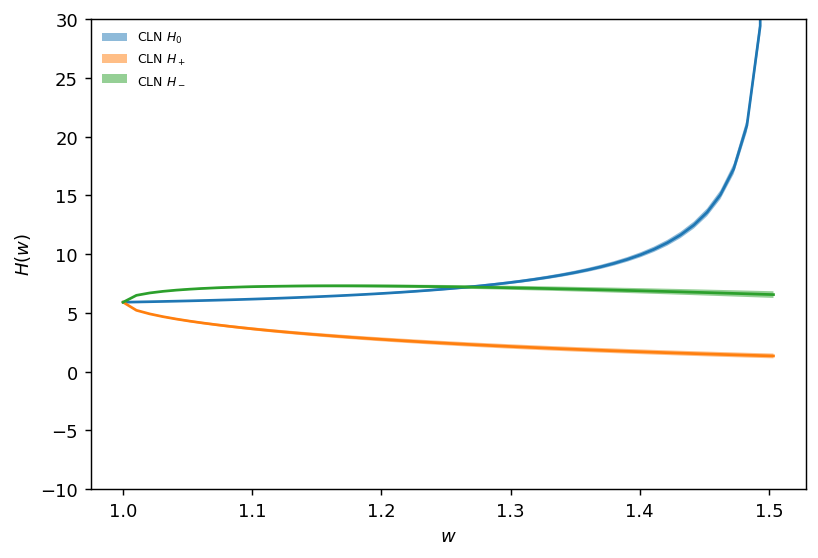

In [77]:
Hzero = [rate_cln.FF.Hzero(w_) for w_ in w_range]
Hplus = [rate_cln.FF.Hplus(w_) for w_ in w_range]
Hminus = [rate_cln.FF.Hminus(w_) for w_ in w_range]

fig, ax = plt.subplots(dpi=130, figsize=(6.4, 4.4))

index = f"{a}{b}{c}"
ax.plot(w_range, unp.nominal_values(Hzero))
ax.fill_between(
    w_range, 
    unp.nominal_values(Hzero) + unp.std_devs(Hzero),
    unp.nominal_values(Hzero) - unp.std_devs(Hzero),
    alpha=0.5,
    label=f"CLN $H_0$"
)

ax.plot(w_range, unp.nominal_values(Hplus))
ax.fill_between(
    w_range, 
    unp.nominal_values(Hplus) + unp.std_devs(Hplus),
    unp.nominal_values(Hplus) - unp.std_devs(Hplus),
    alpha=0.5,
    label=f"CLN $H_+$"
)

ax.plot(w_range, unp.nominal_values(Hminus))
ax.fill_between(
    w_range, 
    unp.nominal_values(Hminus) + unp.std_devs(Hminus),
    unp.nominal_values(Hminus) - unp.std_devs(Hminus),
    alpha=0.5,
    label=f"CLN $H_-$"
)

ax.set_ylim(-10, 30)
ax.set_ylabel(r"$H(w)$")
ax.set_xlabel(r"$w$")
ax.legend(frameon=False, fontsize="x-small", ncol=1, loc='upper left')

plt.tight_layout()
plt.show()
plt.close()

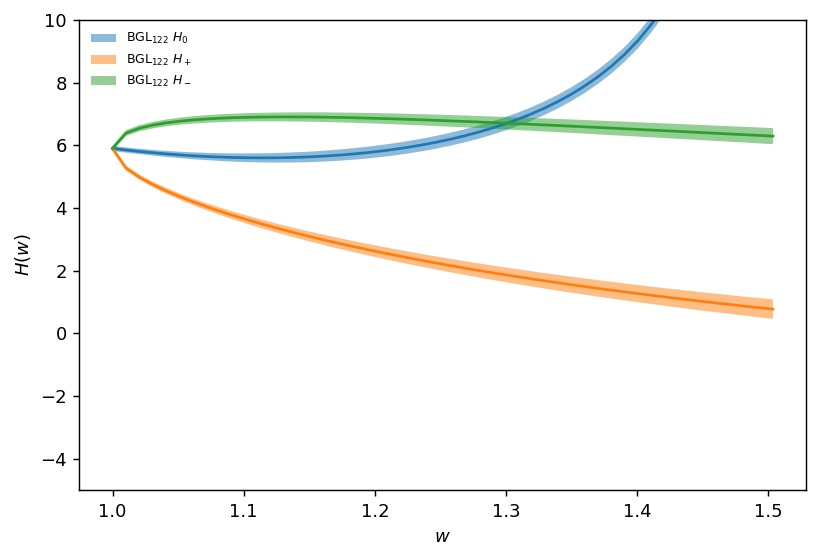

In [78]:
Hzero = [rate_bgl.FF.Hzero(w_) for w_ in w_range]
Hplus = [rate_bgl.FF.Hplus(w_) for w_ in w_range]
Hminus = [rate_bgl.FF.Hminus(w_) for w_ in w_range]

fig, ax = plt.subplots(dpi=130, figsize=(6.4, 4.4))

index = f"{a}{b}{c}"
ax.plot(w_range, unp.nominal_values(Hzero))
ax.fill_between(
    w_range, 
    unp.nominal_values(Hzero) + unp.std_devs(Hzero),
    unp.nominal_values(Hzero) - unp.std_devs(Hzero),
    alpha=0.5,
    label=f"BGL$_{{{index}}}$ $H_0$"
)

ax.plot(w_range, unp.nominal_values(Hplus))
ax.fill_between(
    w_range, 
    unp.nominal_values(Hplus) + unp.std_devs(Hplus),
    unp.nominal_values(Hplus) - unp.std_devs(Hplus),
    alpha=0.5,
    label=f"BGL$_{{{index}}}$ $H_+$"
)

ax.plot(w_range, unp.nominal_values(Hminus))
ax.fill_between(
    w_range, 
    unp.nominal_values(Hminus) + unp.std_devs(Hminus),
    unp.nominal_values(Hminus) - unp.std_devs(Hminus),
    alpha=0.5,
    label=f"BGL$_{{{index}}}$ $H_-$"
)

ax.set_ylim(-5, 10)
ax.set_ylabel(r"$H(w)$")
ax.set_xlabel(r"$w$")
ax.legend(frameon=False, fontsize="x-small", ncol=1, loc='upper left')

plt.tight_layout()
plt.show()
plt.close()

In [79]:
total_rate = rate_bgl.Gamma()
w_rate = [rate_bgl.dGamma_dw(w) / total_rate       * (max(w_range) - min(w_range))       for w in w_range]
cosL_rate = [rate_bgl.dGamma_dcosL(w) / total_rate * (max(cosL_range) - min(cosL_range)) for w in cosL_range]
cosV_rate = [rate_bgl.dGamma_dcosV(w) / total_rate * (max(cosV_range) - min(cosV_range)) for w in cosV_range]
chi_rate = [rate_bgl.dGamma_dchi(w) / total_rate   * (max(chi_range) - min(chi_range))   for w in chi_range]

In [80]:
total_rate_cln = rate_cln.Gamma()
w_rate_cln = [rate_cln.dGamma_dw(w) / total_rate_cln       * (max(w_range) - min(w_range))       for w in w_range]
cosL_rate_cln = [rate_cln.dGamma_dcosL(w) / total_rate_cln * (max(cosL_range) - min(cosL_range)) for w in cosL_range]
cosV_rate_cln = [rate_cln.dGamma_dcosV(w) / total_rate_cln * (max(cosV_range) - min(cosV_range)) for w in cosV_range]
chi_rate_cln = [rate_cln.dGamma_dchi(w) / total_rate_cln   * (max(chi_range) - min(chi_range))   for w in chi_range]

In [81]:
total_rate_lattice = rate_lattice.Gamma()
#w_rate_lattice = [rate_lattice.dGamma_dw(w) / total_rate_lattice       * (max(w_range) - min(w_range))       for w in w_range]
#cosL_rate_lattice = [rate_lattice.dGamma_dcosL(w) / total_rate_lattice * (max(cosL_range) - min(cosL_range)) for w in cosL_range]
#cosV_rate_lattice = [rate_lattice.dGamma_dcosV(w) / total_rate_lattice * (max(cosV_range) - min(cosV_range)) for w in cosV_range]
#chi_rate_lattice = [rate_lattice.dGamma_dchi(w) / total_rate_lattice   * (max(chi_range) - min(chi_range))   for w in chi_range]

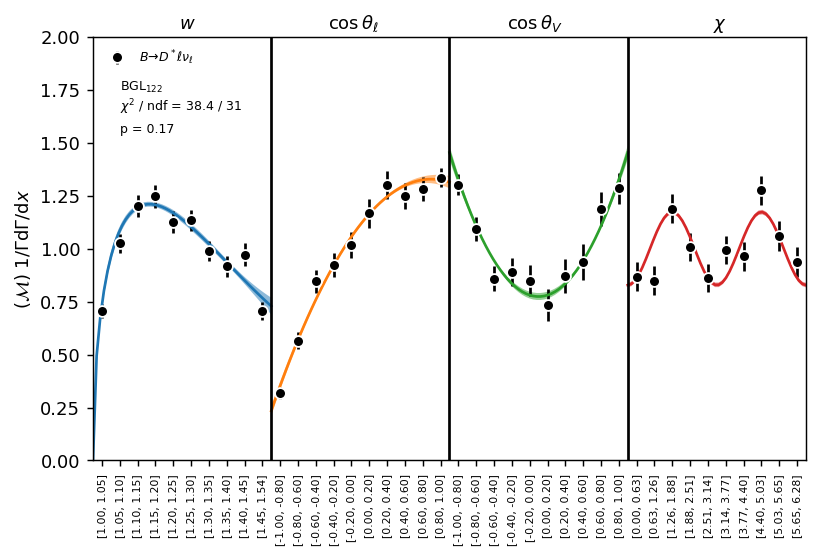

In [82]:
fig, ax = plt.subplots(dpi=130, figsize=(6.4, 4.4))

result = get_full_spectrum(m_average)

ax.errorbar(
    x=[x for x in range(0, 40)],
    y=unp.nominal_values(result) / tmp_bw ,
    yerr=unp.std_devs(result) / tmp_bw,
    marker='o', color="black", ls="", markeredgecolor='white', label=r"$B \to D^* \ell \nu_\ell$",
)

index = f"{a}{b}{c}"
ax.plot(np.linspace( 0-0.5, 10-0.5), unp.nominal_values(w_rate))
ax.fill_between(
    np.linspace( 0-0.5, 10-0.5), 
    unp.nominal_values(w_rate) + unp.std_devs(w_rate),
    unp.nominal_values(w_rate) - unp.std_devs(w_rate),
    alpha=0.5
)
ax.plot(np.linspace(10-0.5, 20-0.5), unp.nominal_values(cosL_rate))
ax.fill_between(
    np.linspace(10-0.5, 20-0.5),
    unp.nominal_values(cosL_rate) + unp.std_devs(cosL_rate),
    unp.nominal_values(cosL_rate) - unp.std_devs(cosL_rate),
    alpha=0.5
)
ax.plot(np.linspace(20-0.5, 30-0.5), unp.nominal_values(cosV_rate))
ax.fill_between(
    np.linspace(20-0.5, 30-0.5), 
    unp.nominal_values(cosV_rate) + unp.std_devs(cosV_rate),
    unp.nominal_values(cosV_rate) - unp.std_devs(cosV_rate),
    alpha=0.5
)
ax.plot(np.linspace(30-0.5, 40-0.5), unp.nominal_values(chi_rate))
ax.fill_between(
    np.linspace(30-0.5, 40-0.5), 
    unp.nominal_values(chi_rate) + unp.std_devs(chi_rate),
    unp.nominal_values(chi_rate) - unp.std_devs(chi_rate),
    alpha=0.5
)

make_plot_pretty(ax, bin_edges_all)
ax.set_ylim(0, 2)
ax.set_ylabel(r"$(\mathcal{M}$) $1 / \Gamma \mathrm{d} \Gamma / \mathrm{d}x$")
ax.text(1, 1.75, f"BGL$_{{{index}}}$", size="x-small")
ax.text(1, 1.65, f"$\chi^2$ / ndf = {m_bgl.fval:.1f} / {36-(a+b+c)}", size="x-small")
ax.text(1, 1.55, f"p = {scipy.stats.chi2.sf(m_bgl.fval, df=36-(a+b+c)):.2f}", size="x-small")

plt.savefig(os.path.join(result_dir, f"BGL{a}{b}{c}.pdf"), transparent=True)
plt.savefig(os.path.join(result_dir, f"BGL{a}{b}{c}.png"), transparent=True)

plt.tight_layout()
plt.show()
plt.close()

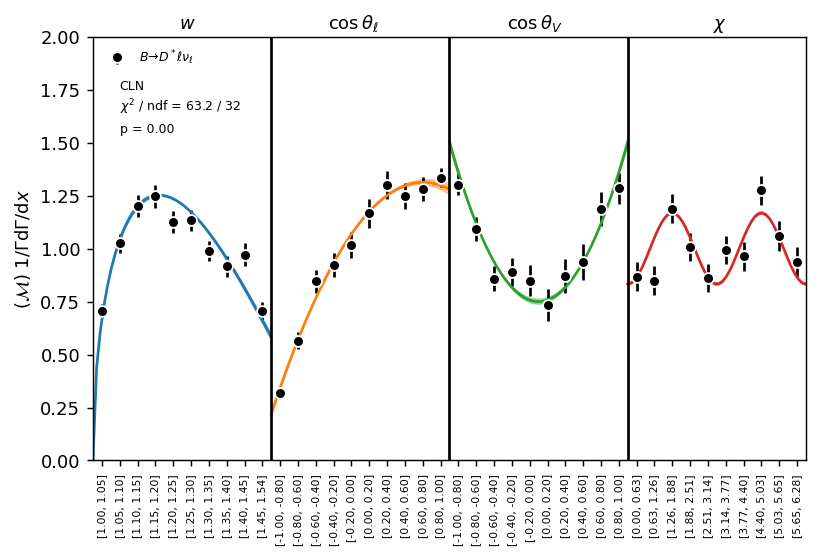

In [83]:
fig, ax = plt.subplots(dpi=130, figsize=(6.4, 4.4))

result = get_full_spectrum(m_average)

ax.errorbar(
    x=[x for x in range(0, 40)],
    y=unp.nominal_values(result) / tmp_bw ,
    yerr=unp.std_devs(result) / tmp_bw,
    marker='o', color="black", ls="", markeredgecolor='white', label=r"$B \to D^* \ell \nu_\ell$",
)

ax.plot(np.linspace( 0-0.5, 10-0.5), unp.nominal_values(w_rate_cln))
ax.fill_between(
    np.linspace( 0-0.5, 10-0.5), 
    unp.nominal_values(w_rate_cln) + unp.std_devs(w_rate_cln),
    unp.nominal_values(w_rate_cln) - unp.std_devs(w_rate_cln),
    alpha=0.5
)
ax.plot(np.linspace(10-0.5, 20-0.5), unp.nominal_values(cosL_rate_cln))
ax.fill_between(
    np.linspace(10-0.5, 20-0.5),
    unp.nominal_values(cosL_rate_cln) + unp.std_devs(cosL_rate_cln),
    unp.nominal_values(cosL_rate_cln) - unp.std_devs(cosL_rate_cln),
    alpha=0.5
)
ax.plot(np.linspace(20-0.5, 30-0.5), unp.nominal_values(cosV_rate_cln))
ax.fill_between(
    np.linspace(20-0.5, 30-0.5), 
    unp.nominal_values(cosV_rate_cln) + unp.std_devs(cosV_rate_cln),
    unp.nominal_values(cosV_rate_cln) - unp.std_devs(cosV_rate_cln),
    alpha=0.5
)
ax.plot(np.linspace(30-0.5, 40-0.5), unp.nominal_values(chi_rate_cln))
ax.fill_between(
    np.linspace(30-0.5, 40-0.5), 
    unp.nominal_values(chi_rate_cln) + unp.std_devs(chi_rate_cln),
    unp.nominal_values(chi_rate_cln) - unp.std_devs(chi_rate_cln),
    alpha=0.5
)

make_plot_pretty(ax, bin_edges_all)
ax.set_ylim(0, 2)
ax.set_ylabel(r"$(\mathcal{M}$) $1 / \Gamma \mathrm{d} \Gamma / \mathrm{d}x$")
ax.text(1, 1.75, f"CLN", size="x-small")
ax.text(1, 1.65, f"$\chi^2$ / ndf = {m_cln.fval:.1f} / 32", size="x-small")
ax.text(1, 1.55, f"p = {scipy.stats.chi2.sf(m_cln.fval, df=36-4):.2f}", size="x-small")

plt.savefig(os.path.join(result_dir, "CLN.pdf"), transparent=True)
plt.savefig(os.path.join(result_dir, "CLN.png"), transparent=True)

plt.tight_layout()
plt.show()
plt.close()

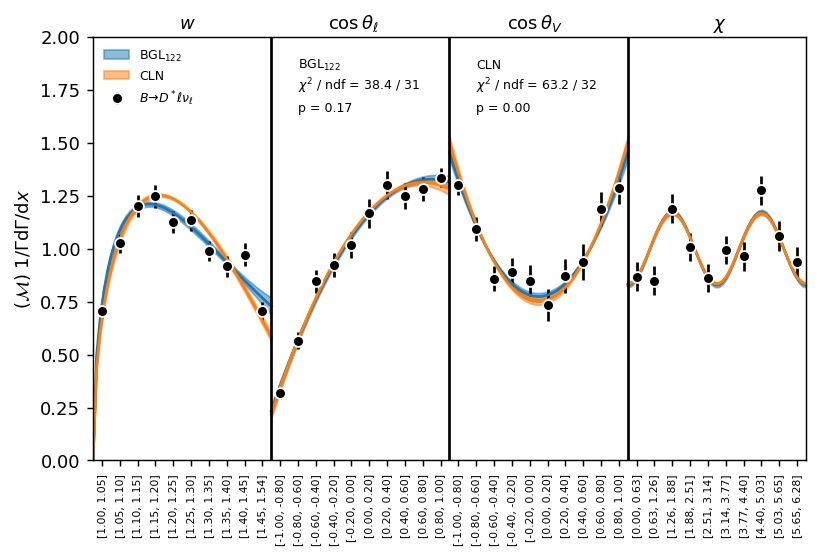

In [84]:
fig, ax = plt.subplots(dpi=130, figsize=(6.4, 4.4))

result = get_full_spectrum(m_average)

ax.errorbar(
    x=[x for x in range(0, 40)],
    y=unp.nominal_values(result) / tmp_bw ,
    yerr=unp.std_devs(result) / tmp_bw,
    marker='o', color="black", ls="", markeredgecolor='white', label=r"$B \to D^* \ell \nu_\ell$",
)

# ax.plot(np.linspace( 0-0.5, 10-0.5), unp.nominal_values(w_rate_lattice), color="tab:grey")
# ax.fill_between(
#     np.linspace( 0-0.5, 10-0.5), 
#     unp.nominal_values(w_rate_lattice) + unp.std_devs(w_rate_lattice),
#     unp.nominal_values(w_rate_lattice) - unp.std_devs(w_rate_lattice),
#     alpha=0.5, color="tab:grey", label="Lattice"
# )
# ax.plot(np.linspace(10-0.5, 20-0.5), unp.nominal_values(cosL_rate_lattice), color="tab:grey")
# ax.fill_between(
#     np.linspace(10-0.5, 20-0.5),
#     unp.nominal_values(cosL_rate_lattice) + unp.std_devs(cosL_rate_lattice),
#     unp.nominal_values(cosL_rate_lattice) - unp.std_devs(cosL_rate_lattice),
#     alpha=0.5, color="tab:grey"
# )
# ax.plot(np.linspace(20-0.5, 30-0.5), unp.nominal_values(cosV_rate_lattice), color="tab:grey")
# ax.fill_between(
#     np.linspace(20-0.5, 30-0.5), 
#     unp.nominal_values(cosV_rate_lattice) + unp.std_devs(cosV_rate_lattice),
#     unp.nominal_values(cosV_rate_lattice) - unp.std_devs(cosV_rate_lattice),
#     alpha=0.5, color="tab:grey"
# )
# ax.plot(np.linspace(30-0.5, 40-0.5), unp.nominal_values(chi_rate_lattice), color="tab:grey")
# ax.fill_between(
#     np.linspace(30-0.5, 40-0.5), 
#     unp.nominal_values(chi_rate_lattice) + unp.std_devs(chi_rate_lattice),
#     unp.nominal_values(chi_rate_lattice) - unp.std_devs(chi_rate_lattice),
#     alpha=0.5, color="tab:grey"
# )

index = f"{a}{b}{c}"
ax.plot(np.linspace( 0-0.5, 10-0.5), unp.nominal_values(w_rate), color="tab:blue")
ax.fill_between(
    np.linspace( 0-0.5, 10-0.5), 
    unp.nominal_values(w_rate) + unp.std_devs(w_rate),
    unp.nominal_values(w_rate) - unp.std_devs(w_rate),
    alpha=0.5, color="tab:blue", label=f"BGL$_{{{index}}}$"
)
ax.plot(np.linspace(10-0.5, 20-0.5), unp.nominal_values(cosL_rate), color="tab:blue")
ax.fill_between(
    np.linspace(10-0.5, 20-0.5),
    unp.nominal_values(cosL_rate) + unp.std_devs(cosL_rate),
    unp.nominal_values(cosL_rate) - unp.std_devs(cosL_rate),
    alpha=0.5, color="tab:blue"
)
ax.plot(np.linspace(20-0.5, 30-0.5), unp.nominal_values(cosV_rate), color="tab:blue")
ax.fill_between(
    np.linspace(20-0.5, 30-0.5), 
    unp.nominal_values(cosV_rate) + unp.std_devs(cosV_rate),
    unp.nominal_values(cosV_rate) - unp.std_devs(cosV_rate),
    alpha=0.5, color="tab:blue"
)
ax.plot(np.linspace(30-0.5, 40-0.5), unp.nominal_values(chi_rate), color="tab:blue")
ax.fill_between(
    np.linspace(30-0.5, 40-0.5), 
    unp.nominal_values(chi_rate) + unp.std_devs(chi_rate),
    unp.nominal_values(chi_rate) - unp.std_devs(chi_rate),
    alpha=0.5, color="tab:blue"
)


ax.plot(np.linspace( 0-0.5, 10-0.5), unp.nominal_values(w_rate_cln), color="tab:orange")
ax.fill_between(
    np.linspace( 0-0.5, 10-0.5), 
    unp.nominal_values(w_rate_cln) + unp.std_devs(w_rate_cln),
    unp.nominal_values(w_rate_cln) - unp.std_devs(w_rate_cln),
    alpha=0.5, color="tab:orange", label="CLN"
)
ax.plot(np.linspace(10-0.5, 20-0.5), unp.nominal_values(cosL_rate_cln), color="tab:orange")
ax.fill_between(
    np.linspace(10-0.5, 20-0.5),
    unp.nominal_values(cosL_rate_cln) + unp.std_devs(cosL_rate_cln),
    unp.nominal_values(cosL_rate_cln) - unp.std_devs(cosL_rate_cln),
    alpha=0.5, color="tab:orange"
)
ax.plot(np.linspace(20-0.5, 30-0.5), unp.nominal_values(cosV_rate_cln), color="tab:orange")
ax.fill_between(
    np.linspace(20-0.5, 30-0.5), 
    unp.nominal_values(cosV_rate_cln) + unp.std_devs(cosV_rate_cln),
    unp.nominal_values(cosV_rate_cln) - unp.std_devs(cosV_rate_cln),
    alpha=0.5, color="tab:orange"
)
ax.plot(np.linspace(30-0.5, 40-0.5), unp.nominal_values(chi_rate_cln), color="tab:orange")
ax.fill_between(
    np.linspace(30-0.5, 40-0.5), 
    unp.nominal_values(chi_rate_cln) + unp.std_devs(chi_rate_cln),
    unp.nominal_values(chi_rate_cln) - unp.std_devs(chi_rate_cln),
    alpha=0.5, color="tab:orange"
)

make_plot_pretty(ax, bin_edges_all)
ax.set_ylim(0, 2)
ax.set_ylabel(r"$(\mathcal{M}$) $1 / \Gamma \mathrm{d} \Gamma / \mathrm{d}x$")
ax.text(11, 1.85, f"BGL$_{{{index}}}$", size="x-small")
ax.text(11, 1.75, f"$\chi^2$ / ndf = {m_bgl.fval:.1f} / {36-(a+b+c)}", size="x-small")
ax.text(11, 1.65, f"p = {scipy.stats.chi2.sf(m_bgl.fval, df=36-(a+b+c)):.2f}", size="x-small")

ax.text(21, 1.85, f"CLN", size="x-small")
ax.text(21, 1.75, f"$\chi^2$ / ndf = {m_cln.fval:.1f} / 32", size="x-small")
ax.text(21, 1.65, f"p = {scipy.stats.chi2.sf(m_cln.fval, df=36-4):.2f}", size="x-small")

plt.savefig(os.path.join(result_dir, f"BGL{a}{b}{c}vsCLN.pdf"), transparent=True)
plt.savefig(os.path.join(result_dir, f"BGL{a}{b}{c}vsCLN.png"), transparent=True)

plt.tight_layout()
plt.show()
plt.close()

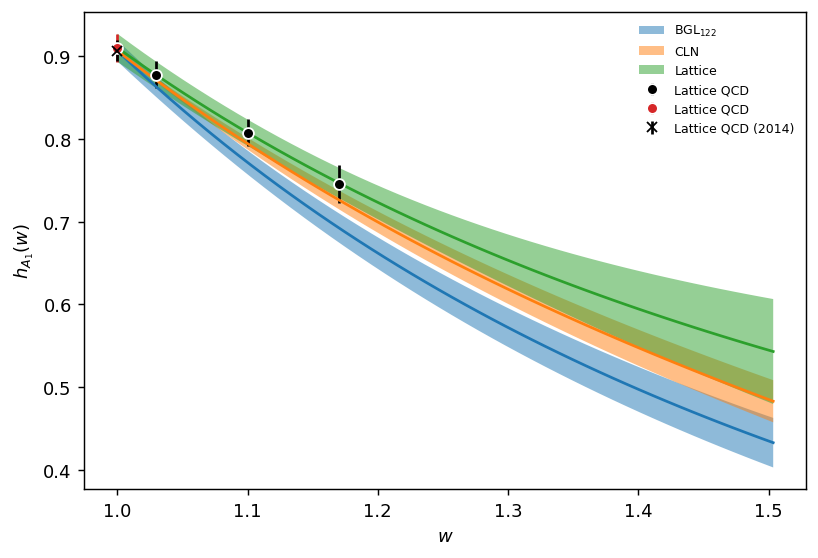

In [85]:
ff_hA1_BGL = [rate_bgl.FF.h_A1(w)  for w in w_range]
ff_hA1_CLN = [rate_cln.FF.h_A1(w)  for w in w_range]
ff_hA1_lattice = [rate_lattice.FF.h_A1(w)  for w in w_range]

fig, ax = plt.subplots(dpi=130, figsize=(6.4, 4.4))

index = f"{a}{b}{c}"
ax.plot(w_range, unp.nominal_values(ff_hA1_BGL))
ax.fill_between(
    w_range, 
    unp.nominal_values(ff_hA1_BGL) + unp.std_devs(ff_hA1_BGL),
    unp.nominal_values(ff_hA1_BGL) - unp.std_devs(ff_hA1_BGL),
    alpha=0.5,
    label=f"BGL$_{{{index}}}$"
)

ax.plot(w_range, unp.nominal_values(ff_hA1_CLN))
ax.fill_between(
    w_range, 
    unp.nominal_values(ff_hA1_CLN) + unp.std_devs(ff_hA1_CLN),
    unp.nominal_values(ff_hA1_CLN) - unp.std_devs(ff_hA1_CLN),
    alpha=0.5,
    label="CLN"
)

ax.plot(w_range, unp.nominal_values(ff_hA1_lattice))
ax.fill_between(
    w_range, 
    unp.nominal_values(ff_hA1_lattice) + unp.std_devs(ff_hA1_lattice),
    unp.nominal_values(ff_hA1_lattice) - unp.std_devs(ff_hA1_lattice),
    alpha=0.5,
    label="Lattice"
)

ax.errorbar(
    x=[1.03, 1.10, 1.17],
    y=unp.nominal_values(hA1_all), 
    yerr=unp.std_devs(hA1_all), 
    marker="o", color="black", markeredgecolor="white", ls="",
    label="Lattice QCD"
)

ax.errorbar(
    x=[1.0],
    y=unp.nominal_values(hA1), 
    yerr=unp.std_devs(hA1), 
    marker="o", color="tab:red", markeredgecolor="white", ls="",
    label="Lattice QCD"
)

ax.errorbar(
    x=[1.0],
    y=unp.nominal_values(hA1_2014), 
    yerr=unp.std_devs(hA1_2014), 
    marker="x", color="black", markeredgecolor="black", ls="",
    label="Lattice QCD (2014)"
)

#ax.set_ylim(0, 1)
ax.set_ylabel(r"$h_{A_1}(w)$")
ax.set_xlabel(r"$w$")
ax.legend(frameon=False, fontsize="x-small", ncol=1, loc='upper right')

plt.tight_layout()
plt.show()
plt.close()

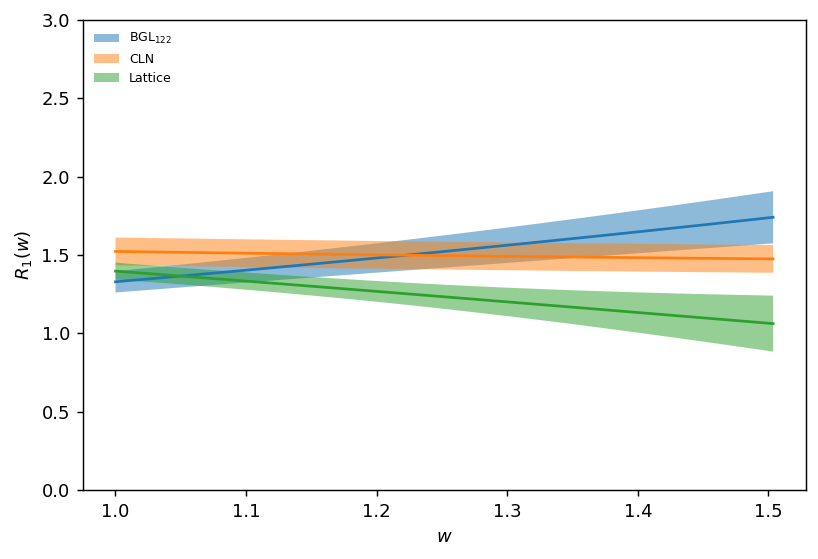

In [86]:
ff_R1_BGL = [rate_bgl.FF.R1(w)  for w in w_range]
ff_R1_CLN = [rate_cln.FF.R1(w)  for w in w_range]
ff_R1_lattice = [rate_lattice.FF.R1(w)  for w in w_range]

fig, ax = plt.subplots(dpi=130, figsize=(6.4, 4.4))

ax.plot(w_range, unp.nominal_values(ff_R1_BGL))
ax.fill_between(
    w_range, 
    unp.nominal_values(ff_R1_BGL) + unp.std_devs(ff_R1_BGL),
    unp.nominal_values(ff_R1_BGL) - unp.std_devs(ff_R1_BGL),
    alpha=0.5,
    label=f"BGL$_{{{index}}}$"
)

ax.plot(w_range, unp.nominal_values(ff_R1_CLN))
ax.fill_between(
    w_range, 
    unp.nominal_values(ff_R1_CLN) + unp.std_devs(ff_R1_CLN),
    unp.nominal_values(ff_R1_CLN) - unp.std_devs(ff_R1_CLN),
    alpha=0.5,
    label="CLN"
)

ax.plot(w_range, unp.nominal_values(ff_R1_lattice))
ax.fill_between(
    w_range, 
    unp.nominal_values(ff_R1_lattice) + unp.std_devs(ff_R1_lattice),
    unp.nominal_values(ff_R1_lattice) - unp.std_devs(ff_R1_lattice),
    alpha=0.5,
    label="Lattice"
)

#ax.errorbar(
#    x=[1.03, 1.10, 1.17],
#    y=unp.nominal_values(hA1_all), 
#    yerr=unp.std_devs(hA1_all), 
#    marker="o", color="black", markeredgecolor="white", ls="",
#    label="Lattice QCD"
#)

ax.set_ylim(0, 3)
ax.set_ylabel(r"$R_1(w)$")
ax.set_xlabel(r"$w$")
ax.legend(frameon=False, fontsize="x-small", ncol=1, loc='upper left')

plt.tight_layout()
plt.show()
plt.close()

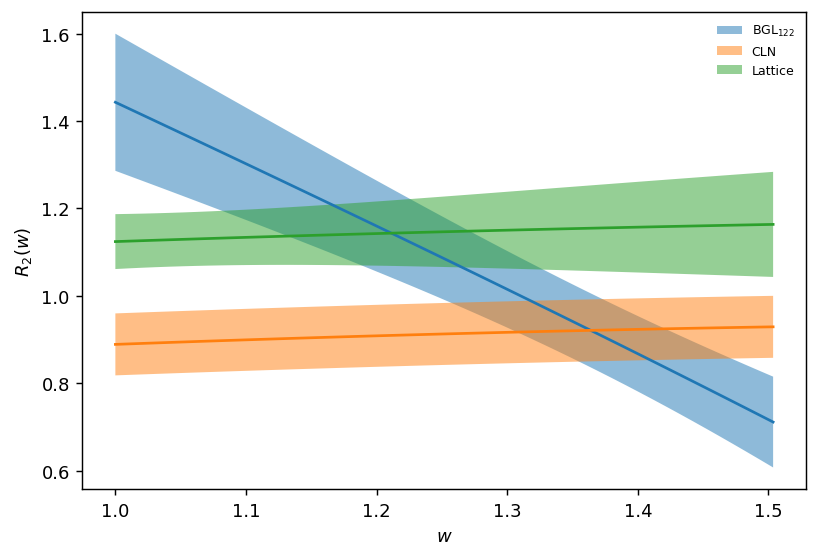

In [87]:
ff_R2_BGL = [rate_bgl.FF.R2(w)  for w in w_range]
ff_R2_CLN = [rate_cln.FF.R2(w)  for w in w_range]
ff_R2_lattice = [rate_lattice.FF.R2(w)  for w in w_range]

fig, ax = plt.subplots(dpi=130, figsize=(6.4, 4.4))

ax.plot(w_range, unp.nominal_values(ff_R2_BGL))
ax.fill_between(
    w_range, 
    unp.nominal_values(ff_R2_BGL) + unp.std_devs(ff_R2_BGL),
    unp.nominal_values(ff_R2_BGL) - unp.std_devs(ff_R2_BGL),
    alpha=0.5,
    label=f"BGL$_{{{index}}}$"
)

ax.plot(w_range, unp.nominal_values(ff_R2_CLN))
ax.fill_between(
    w_range, 
    unp.nominal_values(ff_R2_CLN) + unp.std_devs(ff_R2_CLN),
    unp.nominal_values(ff_R2_CLN) - unp.std_devs(ff_R2_CLN),
    alpha=0.5,
    label="CLN"
)

ax.plot(w_range, unp.nominal_values(ff_R2_lattice))
ax.fill_between(
    w_range, 
    unp.nominal_values(ff_R2_lattice) + unp.std_devs(ff_R2_lattice),
    unp.nominal_values(ff_R2_lattice) - unp.std_devs(ff_R2_lattice),
    alpha=0.5,
    label="Lattice"
)

#ax.errorbar(
#    x=[1.03, 1.10, 1.17],
#    y=unp.nominal_values(hA1_all), 
#    yerr=unp.std_devs(hA1_all), 
#    marker="o", color="black", markeredgecolor="white", ls="",
#    label="Lattice QCD"
#)

#ax.set_ylim(0, 3)
ax.set_ylabel(r"$R_2(w)$")
ax.set_xlabel(r"$w$")
ax.legend(frameon=False, fontsize="x-small", ncol=1, loc='upper right')

plt.tight_layout()
plt.show()
plt.close()

In [88]:
Vcb_HFLAV = ufloat(39.10, 0.50) * 1e-3

In [89]:
BR_BplustoDstarLNu = ufloat(5.66, 0.22) / 100 / tauBplus
BR_BzerotoDstarLNu = ufloat(5.06, 0.12) / 100 / tauBzero

table = pd.DataFrame.from_dict({
    f"$|V_\mathrm{{cb}}| \\times 10^3$ w/ BGL$_{a}{b}{c}$": [(BR_BplustoDstarLNu / rate_bgl.Gamma()) ** 0.5, (BR_BzerotoDstarLNu / rate_bgl.Gamma()) ** 0.5], 
    r"$|V_\mathrm{cb}| \times 10^3$ w/ CLN": [(BR_BplustoDstarLNu / rate_cln.Gamma()) ** 0.5, (BR_BzerotoDstarLNu / rate_cln.Gamma()) ** 0.5], 
    r"$|V_\mathrm{cb}| \times 10^3$ w/ Lattice": [(BR_BplustoDstarLNu / rate_lattice.Gamma()) ** 0.5, (BR_BzerotoDstarLNu / rate_lattice.Gamma()) ** 0.5], 
}, columns=[channel_label["B+"], channel_label["B0"]], orient="index")

table = table.applymap(lambda x: f"{x*1e3:.1f}")
print(table.to_markdown())

|                                            | $B^+ \to D^{*0} \ell \nu_\ell$   | $B^0 \to D^{*+} \ell \nu_\ell$   |
|:-------------------------------------------|:---------------------------------|:---------------------------------|
| $|V_\mathrm{cb}| \times 10^3$ w/ BGL$_122$ | 45.1+/-1.3                       | 44.2+/-1.1                       |
| $|V_\mathrm{cb}| \times 10^3$ w/ CLN       | 42.2+/-1.0                       | 41.4+/-0.7                       |
| $|V_\mathrm{cb}| \times 10^3$ w/ Lattice   | 43.0+/-2.1                       | 42.2+/-1.9                       |
